In [1]:
'''
GCBC with point maze (with multi-goal + color state space)
'''
from __future__ import print_function, division, unicode_literals
%load_ext autoreload
%autoreload 2
import math
import time
import os
import copy
import unicodedata
import string
import re
import random
import io
from io import open

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import distributions as pyd
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import seaborn as sns

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
plt.ion()   # interactive mode - o

from sentence_transformers import SentenceTransformer
lang_model = SentenceTransformer('all-MiniLM-L6-v2', device=device)

In [2]:
# Custom weight init for Conv2D and Linear layers
def weight_init(m):
    if isinstance(m, nn.Linear):
        nn.init.orthogonal_(m.weight.data)
        if hasattr(m.bias, "data"):
            m.bias.data.fill_(0.0)
                
# helper mlp init function
def mlp(input_dim, output_dim, hidden_dim, hidden_depth, output_mod=None):
    if hidden_depth == 0:
        mods = [nn.Linear(input_dim, output_dim)]
    else:
        mods = [nn.Linear(input_dim, hidden_dim), nn.ReLU(inplace=True)]
        for i in range(hidden_depth - 1):
            mods += [nn.Linear(hidden_dim, hidden_dim), nn.ReLU(inplace=True)]
        mods.append(nn.Linear(hidden_dim, output_dim))
    if output_mod is not None:
        mods.append(output_mod)
    trunk = nn.Sequential(*mods)
    return trunk

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

# MLP policy
class MLPPolicy(nn.Module):
    def __init__(
        self, obs_dim, action_dim, hidden_dim, hidden_depth, output_mod=None
    ):
        super().__init__()
        self.trunk = mlp(input_dim, output_dim, hidden_dim, hidden_depth, output_mod)
        self.outputs = dict()
        self.apply(weight_init)

    def forward(self, x):
        return self.trunk(x)

# MLP policy
class CNNPolicy(nn.Module):
    def __init__(
        self, goal_dim, action_dim, hidden_size, mask=False, output_mod=None):
        super().__init__()
        self.mask = mask
        self.goal = mlp(goal_dim, hidden_size, hidden_dim=0, hidden_depth=0, output_mod=None) # => hidden_size
        self.conv = nn.Sequential(
            nn.Conv2d(3,32,kernel_size=8,stride=4), nn.ReLU(inplace=True), nn.BatchNorm2d(32), #(b_size,3,36,36)=>(b_size,32,8,8)
            nn.Conv2d(32,64,kernel_size=4,stride=2), nn.ReLU(inplace=True), nn.BatchNorm2d(64), #(b_size,32,8,8)=>(b_size,64,3,3)
            nn.Conv2d(64,32,kernel_size=3,stride=1), nn.LeakyReLU(inplace=True), Flatten(), nn.BatchNorm1d(32), #(b_size,64,3,3)=>(b_size,32,1,1)=>(b_size,32*1*1)
            nn.Linear(32*1*1, hidden_size), nn.ReLU(inplace=True) #(b_size,32*1*1)=>(b_size,hidden_size)
        )
        self.process = mlp(hidden_size*2, 1*36*36, hidden_dim=0, hidden_depth=0, output_mod=nn.Sigmoid()) #(b_size,hidden_size*2)=>(b_size,32*1*1)
        # UNet deconv mask --------------------------------------------------------------------------------------------------
        #self.deconv = nn.Sequential(
        #    nn.ConvTranspose2d(32, 64, kernel_size=3, stride=1), nn.LeakyReLU(inplace=True), nn.BatchNorm2d(64), #(b_size,32*1*1)=>(b_size,64,3,3)
        #    nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2), nn.LeakyReLU(inplace=True), nn.BatchNorm2d(32), #(b_size,64,3,3)=>(b_size,32,8,8)
        #    nn.ConvTranspose2d(32, 1, kernel_size=8, stride=4), nn.Sigmoid(), #(b_size,32,8,8)=>(b_size,3,36,36)
        #)
        self.cnntrunk = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=8, stride=4), nn.ReLU(inplace=True), nn.BatchNorm2d(32), #(b_size,3,36,36)=>(b_size,32,8,8)
            nn.Conv2d(32, 64, kernel_size=4, stride=2), nn.ReLU(inplace=True), nn.BatchNorm2d(64), #(b_size,32,8,8)=>(b_size,64,3,3)
            nn.Conv2d(64, 32, kernel_size=3, stride=1), nn.ReLU(inplace=True), nn.BatchNorm2d(32), Flatten(), #(b_size,64,3,3)=>(b_size,32,1,1)=>(b_size,32*1*1)
            nn.Linear(32*1*1, hidden_size), nn.ReLU(inplace=True), nn.BatchNorm1d(hidden_size), #(b_size,32*1*1)=>(b_size,hidden_size)
            nn.Linear(hidden_size, action_dim), nn.LeakyReLU(inplace=True) #(b_size,hidden_size)=>(b_size,action_dim)
        )
        self.mlptrunk = mlp(hidden_size*2, action_dim, hidden_dim=100, hidden_depth=1) #(b_size,hidden_size*2)=>(b_size,action_dim)
        self.apply(weight_init)

    def forward(self, goal, state):
        goal_embed = self.goal(goal) # process goal
        state = state.permute(0,3,1,2) # process state
        state_embed = self.conv(state/255.0)
        goal_state = torch.cat((goal_embed,state_embed),dim=1) # process goal + state
        
        if self.mask:
            state_mask = self.process(goal_state)
            state_mask = state_mask.reshape(state_embed.shape[0],1,36,36)
            #state_mask = state_mask.reshape(state_embed.shape[0],32,1,1)
            #state_mask = self.deconv(state_mask) # deconv for mask
            final_state = state * state_mask # apply mask to full state
            pred = self.cnntrunk(final_state)
            return [pred, state_mask, final_state]
        else:
            pred = self.mlptrunk(goal_state)
            return [pred]

In [3]:
# Goal-conditioned Point Maze (with multi state + color)
import gym
import gym.wrappers

class PointEnvComplex(gym.Env):
    def __init__(self):
        self.pos = np.array([99., 99.])
        self.obj1_pos = np.array([99., 99.])
        self.obj1_color = np.array([99., 99., 99.])
        self.obj2_pos = np.array([99., 99.])
        self.obj2_color = np.array([99., 99., 99.])
        self.goal = np.array(['go to the red square'])
        self.goal_pos = np.array([99., 99.])
        self.goal_color = np.array([99., 99., 99.])
        self.max_vel = 1.
        self.observation_space = gym.spaces.Box(
            -np.inf * np.ones(14), np.inf * np.ones(14)
        )
        self.action_space = gym.spaces.Box(-np.ones(2), np.ones(2))
        self.action_space.seed(0)
        self.observation_space.seed(0)

    # creates test env with defined goal locations + colors
    def reset(self, obj_angles=360, obj_colors=[0,1,2], discretize=10):
        self.pos = np.array([0., 0.])
        self.obj1_pos, self.obj1_color = self.gen_obj(obj_angles, obj_colors, discretize)
        self.obj2_pos, self.obj2_color = self.gen_obj(obj_angles, obj_colors, discretize)

        # choose goal from random in objects
        goal_obj = random.randint(1, 2)
        if goal_obj == 1:
            self.goal_pos = self.obj1_pos
            self.goal_color = self.obj1_color
        elif goal_obj == 2:
            self.goal_pos = self.obj2_pos
            self.goal_color = self.obj2_color
        self.goal = np.array(['go to the ' + get_color(self.goal_color) + ' square'])
        return self.get_obs()

    def get_obs(self):
        return copy.deepcopy(np.concatenate([self.pos, self.obj1_pos, self.obj1_color, self.obj2_pos, self.obj2_color, self.goal_color]))
    
    def get_full_obs(self):
        return copy.deepcopy(np.concatenate([self.pos, self.obj1_pos, self.obj1_color, self.obj2_pos, self.obj2_color, self.goal_pos, self.goal_color]))
    
    def step(self, action: np.ndarray):
        self.pos += self.max_vel*action
        reward = -np.linalg.norm((self.pos - self.goal_pos))
        return self.get_full_obs(), reward, False, {}

    # function to generate object based on angles, colors, and discretization ranges
    def gen_obj(self, obj_angles, obj_colors, discretize):
        angle = np.random.uniform(0, obj_angles) # samples angle from range
        angle = round(angle/discretize)*discretize # discretizes to defined range (default 10)
        pos = np.array([5*np.cos(np.deg2rad(angle)), 5*np.sin(np.deg2rad(angle))]) # maps to unit circle
        
        color = np.zeros(shape = 3) # defines total number of colors to choose from
        rand_color = random.sample(obj_colors,1) # samples color from range
        color[rand_color] = 1.
        return pos, color

def get_color(color):
    if color[0] == 1.:
        return 'red'
    elif color[1] == 1.:
        return 'blue'
    elif color[2] == 1.:
        return 'green'

In [4]:
def plot_env(env):
    fig = plt.figure(figsize=(5, 5),facecolor="black")
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    colors = sns.color_palette("hls", 10)
    
    plt.scatter([env.pos[0]],[env.pos[1]], marker='o', color='white', s=30) # plots agent
    plt.scatter([env.obj1_pos[0]],[env.obj1_pos[1]], marker='s', color=get_color(env.obj1_color), s=30) # plots obj1
    plt.scatter([env.obj2_pos[0]],[env.obj2_pos[1]], marker='s', color=get_color(env.obj2_color), s=30) # plots obj2
    plt.scatter([env.goal_pos[0]],[env.goal_pos[1]], marker='*', color=get_color(env.goal_color), s=100) # plots goal
    plt.axis('off')

def plot_full_state(state):
    fig = plt.figure(figsize=(.5, .5),facecolor="black")
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    colors = sns.color_palette("hls", 10)
    
    plt.scatter(state[0], state[1], marker='o', color='white', s=.25) # plots agent
    plt.scatter(state[2], state[3], marker='s', color=get_color(state[4:7]), s=1) # plots obj1
    plt.scatter(state[7], state[8], marker='s', color=get_color(state[9:12]), s=1) # plots obj1
    plt.scatter(state[12], state[13], marker='*', color=get_color(state[14:17]), s=5) # plots goal
    plt.axis('off')
    with io.BytesIO() as buff:
        fig.savefig(buff, format='raw')
        buff.seek(0)
        data = np.frombuffer(buff.getvalue(), dtype=np.uint8)
    w, h = fig.canvas.get_width_height()
    img = data.reshape((int(h), int(w), -1))
    img = img[:,:,:3]
    return img

def plot_construal(state):
    fig = plt.figure(figsize=(.5, .5),facecolor="black")
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    colors = sns.color_palette("hls", 10)
    
    plt.scatter(state[0], state[1], marker='o', color='white', s=.25) # plots agent
    plt.scatter(state[12], state[13], marker='s', color=get_color(state[14:17]), s=1) # plots goal
    plt.axis('off')
    with io.BytesIO() as buff:
        fig.savefig(buff, format='raw')
        buff.seek(0)
        data = np.frombuffer(buff.getvalue(), dtype=np.uint8)
    w, h = fig.canvas.get_width_height()
    img = data.reshape((int(h), int(w), -1))
    img = img[:,:,:3]
    return img

[ 0.          0.         -1.71010072  4.6984631   1.          0.
  0.         -0.86824089 -4.92403877  0.          0.          1.
  0.          0.          1.        ]
['go to the green square']


(36, 36, 3)

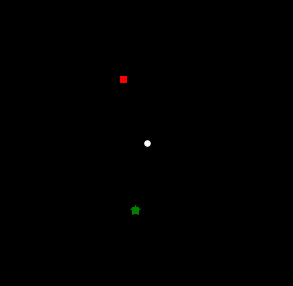

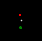

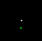

In [5]:
env = PointEnvComplex()
print(env.reset(obj_angles=360, obj_colors=[0,1,2], discretize=10))
print(env.goal)
plot_env(env)
img = plot_full_state(env.get_full_obs())
construal = plot_construal(env.get_full_obs())
img.shape

In [6]:
# generates random trajs within specified constraints
def gen_trajs(env, num_trajs=1, obj_angles=360, obj_colors=[0,1,2], discretize=10):
    trajs = []
    for traj in range(num_trajs):
        env.reset(obj_angles, obj_colors, discretize)
        plot_env(env)
        # rolls out a trajectory towards the goal
        traj = {'obs': [],'acts': [],'goal': [],'construals': []}
        delta_vector = env.goal_pos
        o = plot_full_state(env.get_full_obs())
        construal = plot_construal(env.get_full_obs())
        for i in range(20):
            act = delta_vector * 0.05 # Go in direction between start and end
            no, r, d, _ = env.step(act)
            traj['obs'].append(o.copy())
            traj['acts'].append(act.copy())
            traj['goal'].append(env.goal_color)
            traj['construals'].append(construal.copy())
            #traj['goal'].append(env.goal)
            o = plot_full_state(no.copy())
            construal = plot_construal(no.copy())
        traj['obs'] = np.array(traj['obs'])
        traj['acts'] = np.array(traj['acts'])
        traj['goal'] = np.array(traj['goal'])
        traj['construals'] = np.array(traj['construals'])
        #plt.plot(traj['obs'][:, 0], traj['obs'][:, 1]) # plots trajs + goals
        trajs.append(traj)
    return trajs

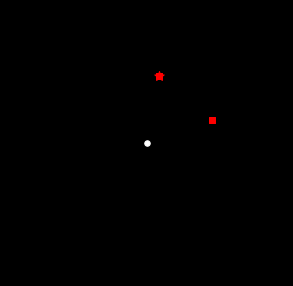

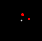

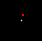

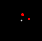

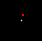

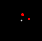

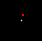

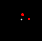

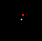

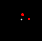

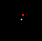

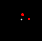

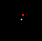

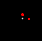

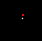

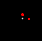

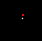

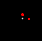

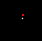

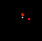

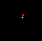

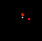

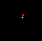

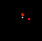

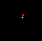

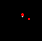

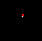

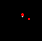

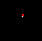

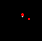

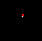

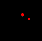

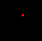

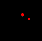

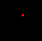

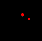

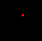

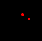

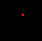

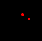

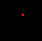

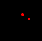

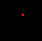

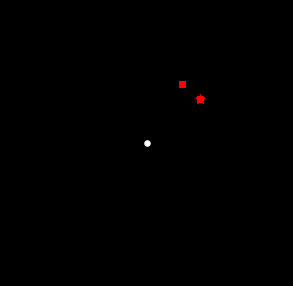

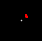

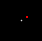

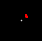

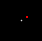

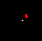

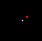

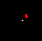

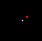

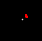

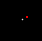

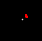

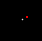

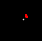

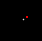

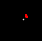

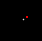

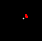

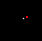

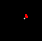

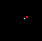

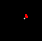

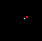

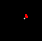

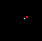

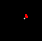

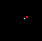

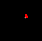

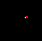

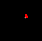

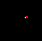

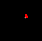

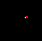

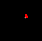

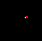

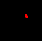

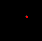

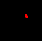

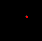

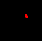

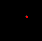

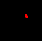

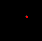

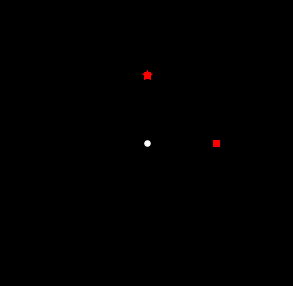

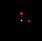

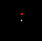

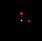

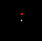

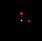

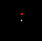

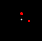

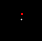

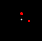

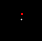

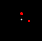

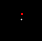

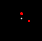

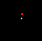

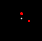

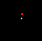

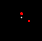

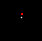

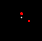

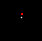

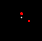

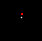

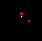

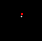

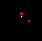

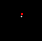

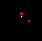

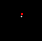

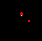

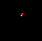

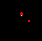

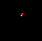

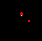

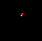

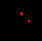

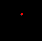

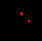

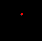

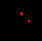

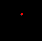

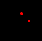

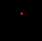

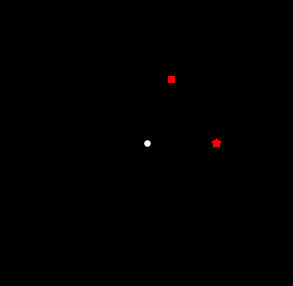

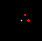

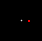

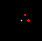

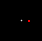

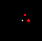

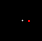

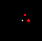

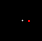

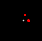

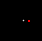

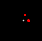

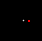

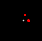

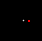

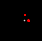

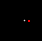

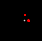

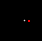

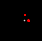

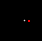

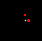

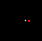

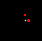

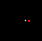

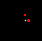

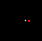

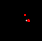

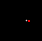

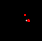

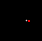

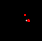

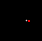

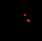

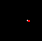

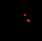

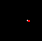

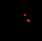

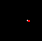

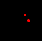

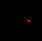

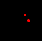

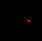

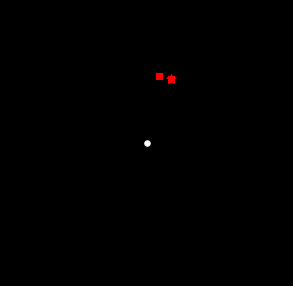

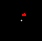

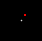

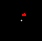

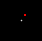

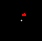

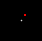

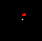

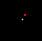

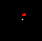

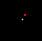

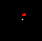

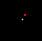

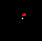

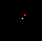

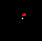

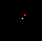

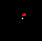

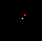

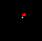

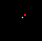

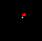

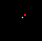

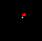

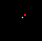

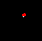

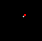

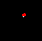

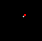

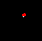

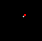

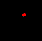

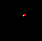

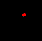

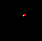

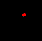

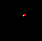

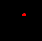

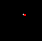

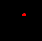

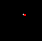

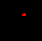

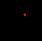

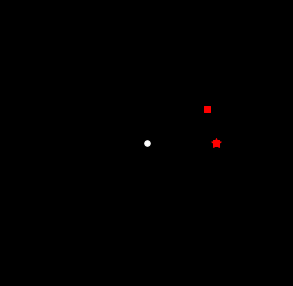

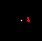

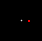

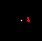

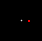

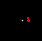

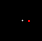

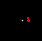

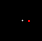

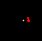

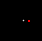

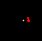

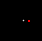

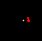

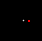

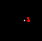

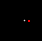

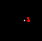

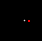

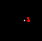

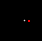

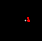

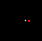

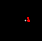

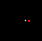

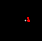

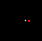

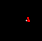

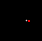

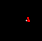

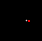

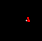

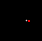

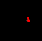

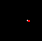

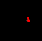

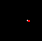

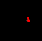

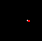

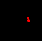

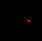

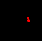

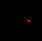

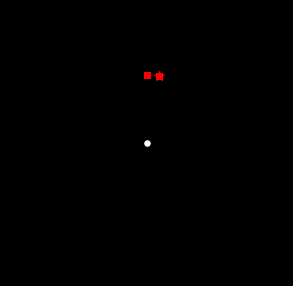

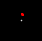

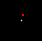

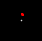

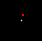

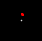

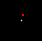

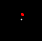

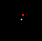

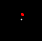

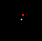

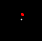

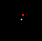

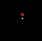

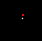

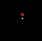

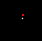

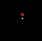

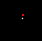

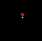

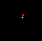

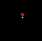

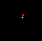

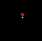

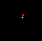

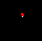

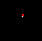

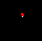

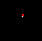

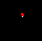

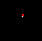

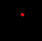

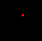

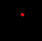

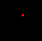

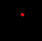

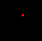

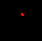

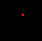

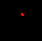

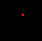

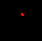

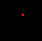

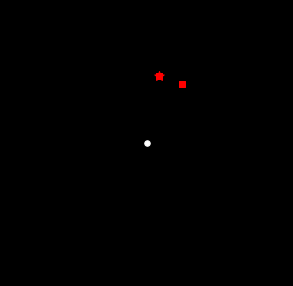

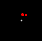

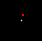

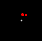

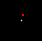

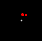

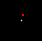

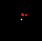

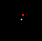

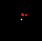

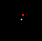

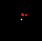

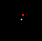

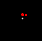

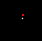

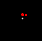

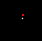

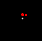

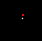

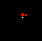

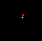

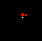

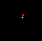

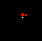

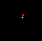

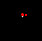

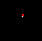

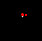

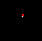

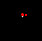

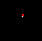

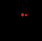

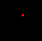

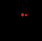

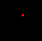

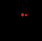

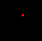

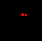

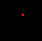

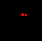

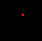

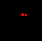

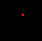

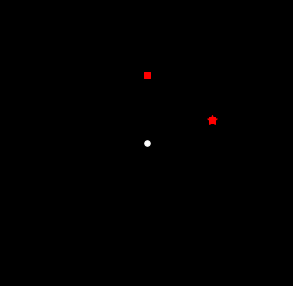

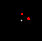

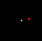

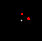

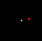

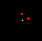

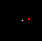

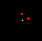

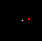

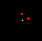

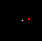

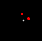

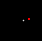

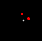

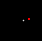

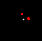

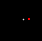

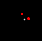

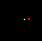

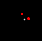

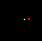

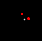

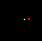

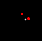

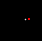

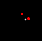

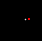

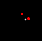

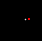

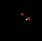

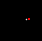

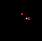

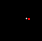

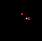

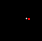

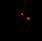

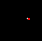

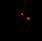

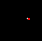

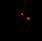

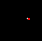

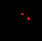

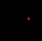

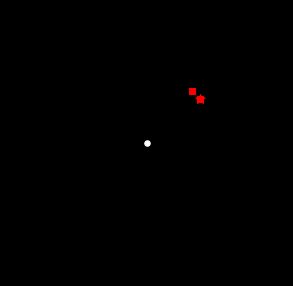

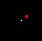

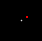

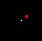

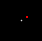

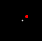

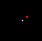

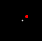

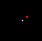

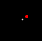

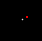

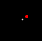

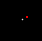

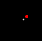

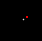

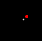

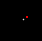

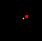

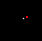

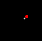

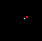

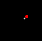

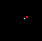

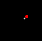

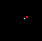

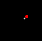

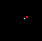

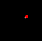

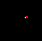

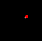

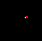

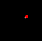

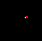

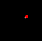

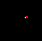

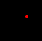

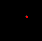

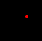

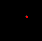

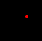

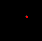

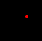

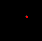

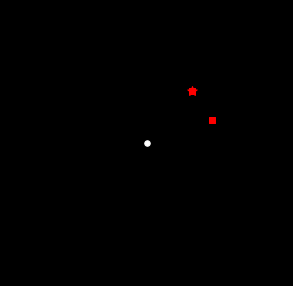

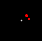

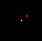

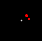

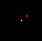

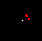

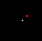

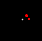

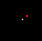

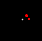

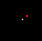

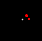

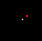

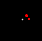

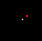

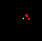

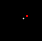

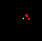

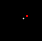

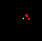

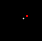

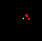

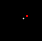

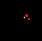

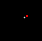

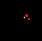

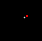

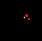

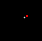

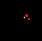

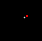

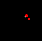

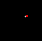

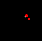

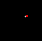

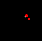

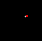

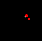

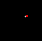

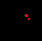

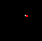

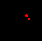

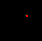

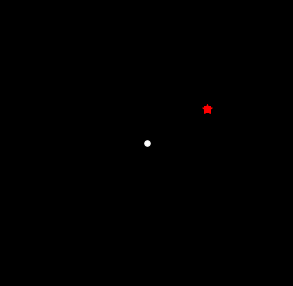

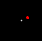

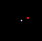

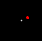

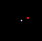

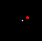

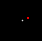

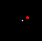

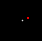

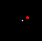

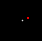

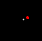

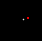

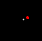

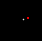

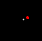

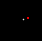

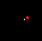

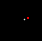

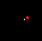

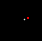

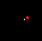

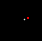

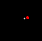

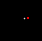

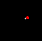

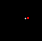

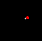

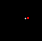

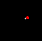

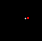

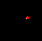

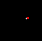

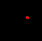

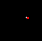

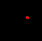

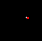

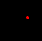

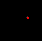

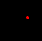

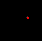

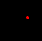

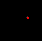

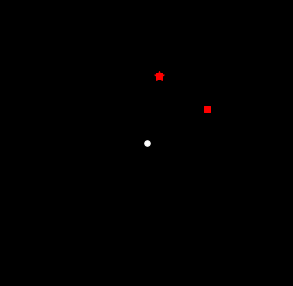

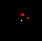

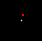

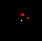

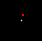

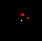

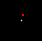

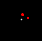

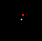

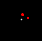

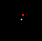

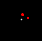

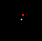

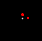

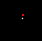

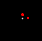

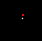

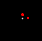

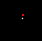

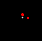

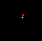

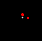

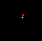

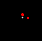

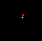

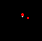

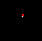

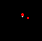

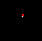

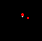

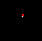

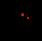

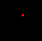

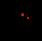

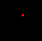

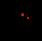

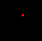

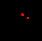

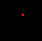

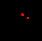

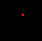

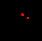

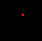

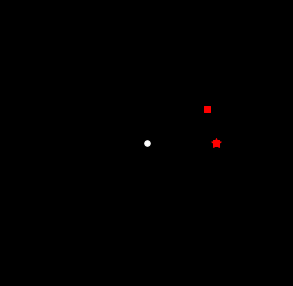

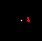

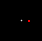

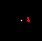

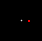

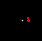

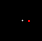

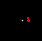

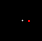

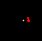

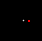

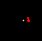

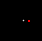

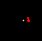

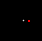

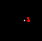

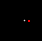

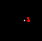

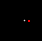

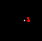

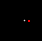

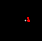

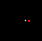

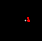

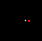

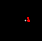

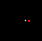

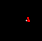

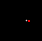

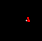

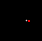

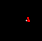

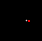

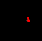

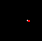

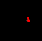

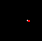

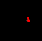

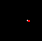

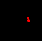

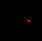

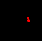

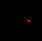

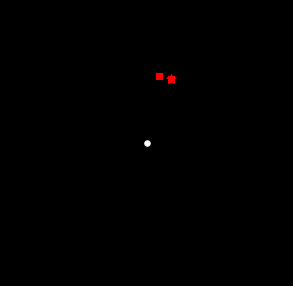

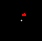

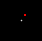

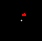

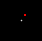

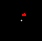

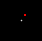

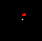

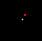

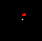

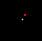

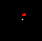

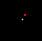

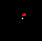

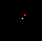

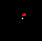

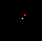

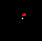

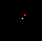

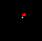

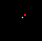

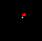

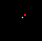

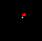

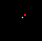

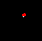

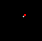

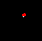

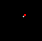

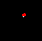

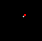

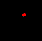

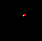

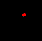

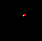

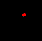

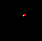

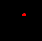

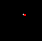

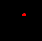

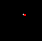

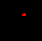

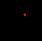

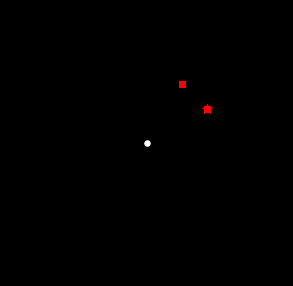

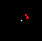

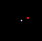

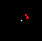

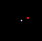

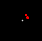

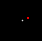

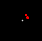

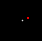

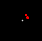

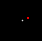

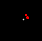

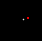

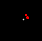

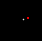

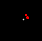

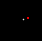

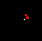

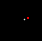

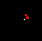

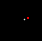

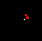

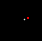

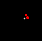

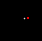

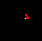

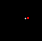

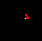

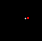

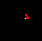

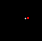

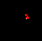

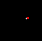

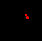

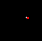

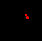

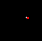

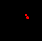

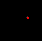

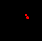

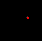

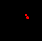

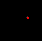

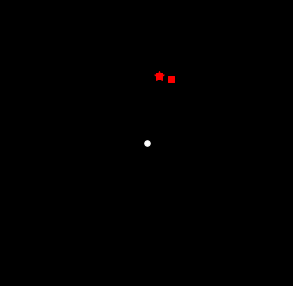

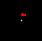

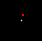

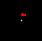

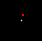

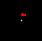

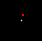

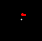

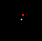

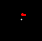

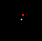

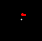

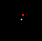

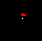

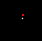

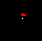

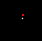

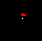

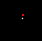

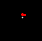

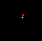

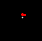

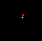

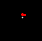

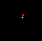

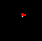

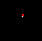

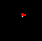

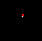

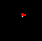

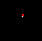

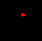

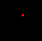

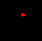

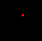

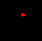

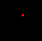

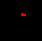

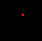

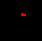

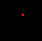

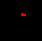

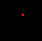

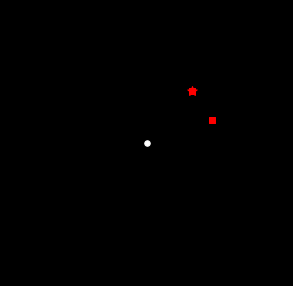

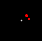

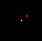

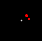

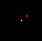

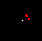

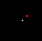

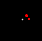

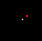

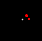

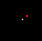

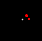

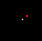

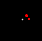

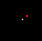

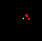

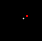

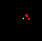

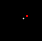

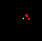

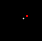

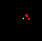

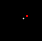

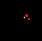

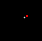

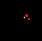

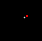

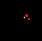

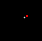

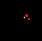

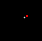

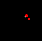

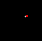

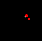

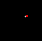

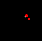

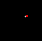

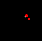

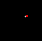

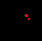

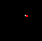

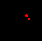

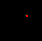

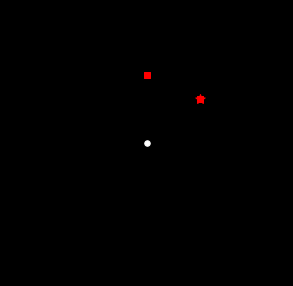

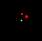

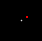

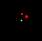

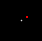

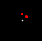

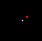

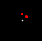

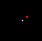

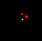

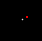

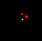

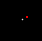

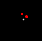

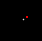

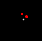

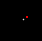

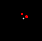

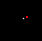

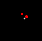

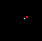

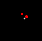

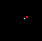

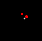

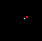

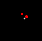

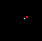

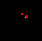

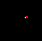

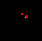

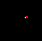

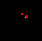

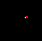

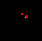

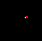

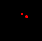

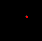

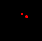

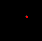

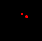

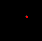

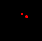

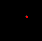

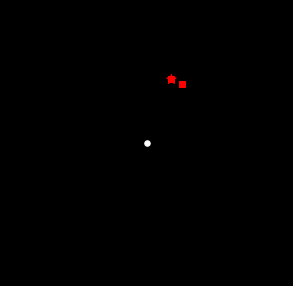

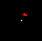

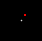

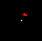

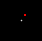

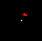

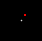

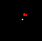

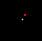

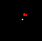

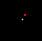

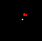

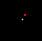

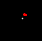

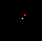

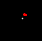

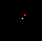

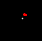

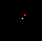

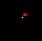

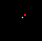

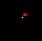

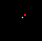

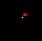

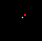

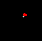

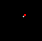

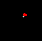

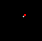

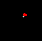

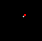

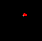

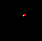

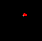

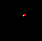

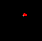

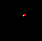

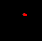

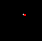

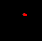

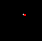

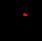

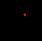

In [214]:
env = PointEnvComplex()
trajs = gen_trajs(env, num_trajs=20, obj_angles=90, obj_colors=[0], discretize=10)

[1. 0. 0.]


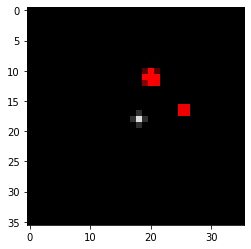

In [215]:
state = trajs[0]['obs'][0]
construal = trajs[0]['construals'][0]
print(trajs[0]['goal'][0])
plt.imshow(state)

In [234]:
num_tasks = len(trajs)
horizon = 20

goal_size = 3 #384
env = PointEnvComplex()
act_size = env.action_space.shape[0]
hidden_size = 100
mask = True

policy = CNNPolicy(goal_size, act_size, hidden_size, mask=mask)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
policy.to(device)

CNNPolicy(
  (goal): Sequential(
    (0): Linear(in_features=3, out_features=100, bias=True)
  )
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (4): ReLU(inplace=True)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (7): LeakyReLU(negative_slope=0.01, inplace=True)
    (8): Flatten()
    (9): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Linear(in_features=32, out_features=100, bias=True)
    (11): ReLU(inplace=True)
  )
  (process): Sequential(
    (0): Linear(in_features=200, out_features=1296, bias=True)
    (1): Sigmoid()
  )
  (cnntrunk): Sequential(
    (0): Conv2d(3, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU(inpla

[1,     1] loss: 1.89920473
[1,     1] mask loss: 1.29495585
[1,     1] action loss: 0.60424894
[2,     1] loss: 1.75367761
[2,     1] mask loss: 1.27568781
[2,     1] action loss: 0.47798976
[3,     1] loss: 1.74973118
[3,     1] mask loss: 1.25672913
[3,     1] action loss: 0.49300209
[4,     1] loss: 1.73239338
[4,     1] mask loss: 1.23792338
[4,     1] action loss: 0.49446997
[5,     1] loss: 1.73578048
[5,     1] mask loss: 1.21862078
[5,     1] action loss: 0.51715970
[6,     1] loss: 1.59825265
[6,     1] mask loss: 1.19893599
[6,     1] action loss: 0.39931664
[7,     1] loss: 1.58911204
[7,     1] mask loss: 1.18070686
[7,     1] action loss: 0.40840524
[8,     1] loss: 1.63156474
[8,     1] mask loss: 1.15882301
[8,     1] action loss: 0.47274175
[9,     1] loss: 1.61355281
[9,     1] mask loss: 1.13840449
[9,     1] action loss: 0.47514838
[10,     1] loss: 1.53299415
[10,     1] mask loss: 1.12168837
[10,     1] action loss: 0.41130576
[11,     1] loss: 1.46317351
[11,    

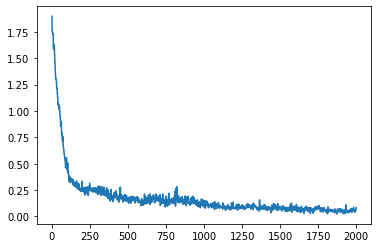

In [235]:
num_epochs = 1000
batch_size = 20

criterion = nn.MSELoss()
optimizer = optim.Adam(list(policy.parameters()))

losses = []

idxs = np.array(range(len(trajs)))

num_batches = len(idxs) // batch_size
# Train the model with regular SGD
for epoch in range(num_epochs):  # loop over the dataset multiple times
    np.random.shuffle(idxs)
    running_loss = 0.0
    for i in range(num_batches):
        optimizer.zero_grad()

        t1_idx = np.random.randint(len(trajs), size=(batch_size,)) # Indices of traj
        t1_idx_pertraj = np.random.randint(20, size=(batch_size,)) # Indices of timesteps in traj
        t1_states = np.concatenate([trajs[c_idx]['obs'][t_idx][None] for (c_idx, t_idx) in zip(t1_idx, t1_idx_pertraj)])
        t1_goals = np.concatenate([trajs[c_idx]['goal'][t_idx][None] for (c_idx, t_idx) in zip(t1_idx, t1_idx_pertraj)])
        #t1_construals = np.concatenate([trajs[c_idx]['construals'][t_idx][None] for (c_idx, t_idx) in zip(t1_idx, t1_idx_pertraj)])
        t1_actions = np.concatenate([trajs[c_idx]['acts'][t_idx][None] for (c_idx, t_idx) in zip(t1_idx, t1_idx_pertraj)])
   
        t1_states = torch.Tensor(t1_states).float().to(device)
        t1_goals = torch.Tensor(t1_goals).float().to(device)
        #t1_goals = torch.Tensor(lang_model.encode(t1_goals.ravel())).float().to(device) # embeds goal through language model dim:384
        #t1_construals = torch.Tensor(t1_construals).float().to(device)
        #t1_construals = t1_construals.permute(0,3,1,2)/255.0 # process channels + norm
        t1_actions = torch.Tensor(t1_actions).float().to(device)
        
        if mask:
            a1_preds, state_mask_preds, _= policy(t1_goals, t1_states)
            mask_loss = 1e-4*state_mask_preds.sum()
        else:
            a1_preds = policy(t1_goals, t1_states)[0]
            mask_loss = 0
        
        action_loss = torch.mean(torch.linalg.norm(a1_preds - t1_actions, dim=-1)) # supervised learning loss
        #construal_loss = 1e-1*((state_mask_preds - t1_construals)*(state_mask_preds - t1_construals)).sum() # MSE supervised construal loss
        loss = action_loss + mask_loss #+ construal_loss
        
        loss.backward()
        #print(policy.conv[0].weight.grad)
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 0:
            print('[%d, %5d] loss: %.8f' %
                  (epoch + 1, i + 1, running_loss))
            print('[%d, %5d] mask loss: %.8f' %
                  (epoch + 1, i + 1, mask_loss))
            print('[%d, %5d] action loss: %.8f' %
                  (epoch + 1, i + 1, action_loss))
            losses.append(running_loss)
            running_loss = 0.0
        losses.append(loss.item())

print('Finished Training')
plt.plot(losses)

Average dist to goal:  -2.5995179002661177
Average std:  1.8544463037116519


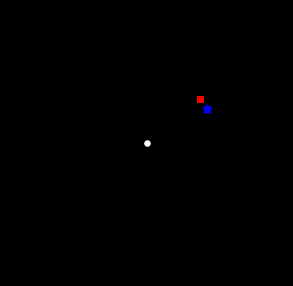

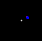

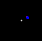

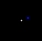

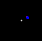

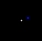

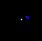

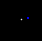

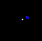

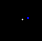

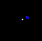

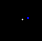

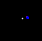

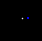

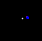

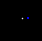

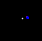

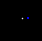

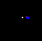

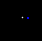

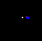

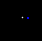

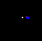

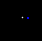

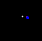

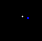

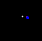

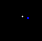

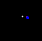

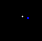

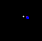

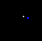

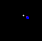

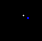

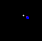

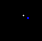

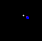

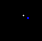

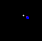

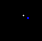

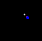

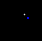

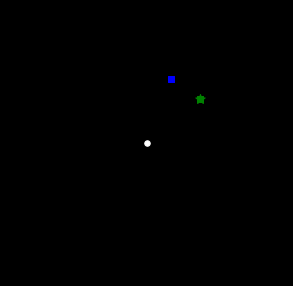

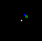

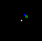

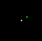

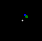

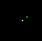

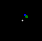

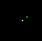

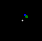

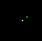

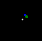

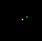

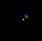

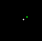

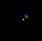

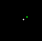

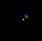

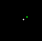

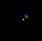

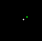

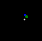

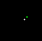

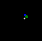

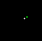

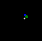

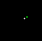

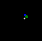

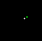

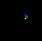

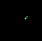

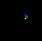

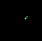

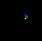

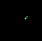

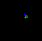

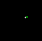

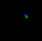

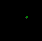

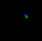

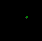

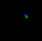

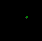

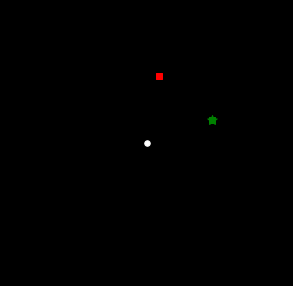

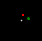

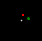

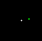

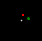

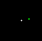

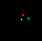

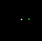

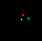

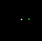

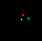

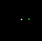

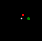

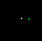

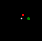

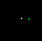

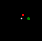

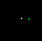

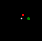

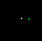

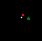

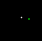

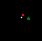

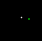

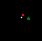

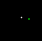

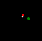

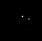

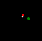

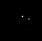

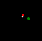

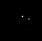

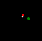

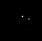

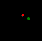

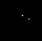

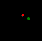

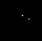

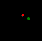

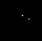

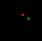

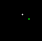

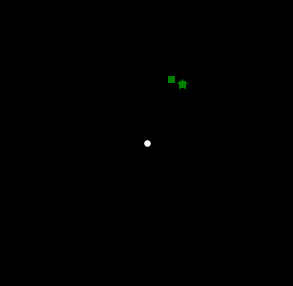

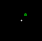

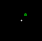

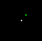

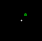

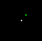

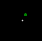

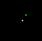

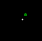

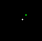

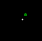

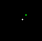

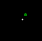

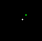

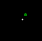

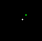

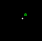

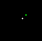

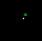

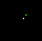

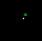

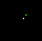

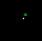

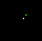

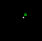

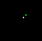

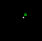

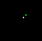

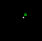

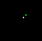

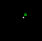

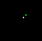

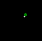

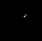

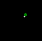

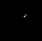

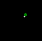

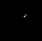

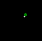

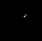

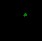

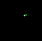

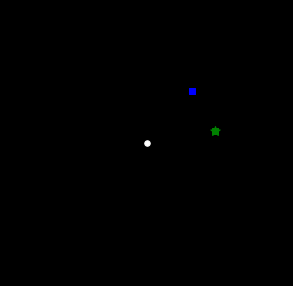

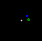

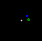

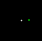

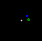

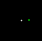

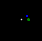

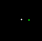

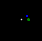

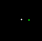

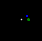

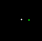

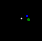

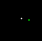

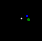

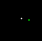

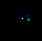

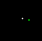

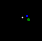

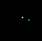

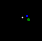

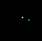

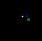

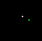

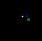

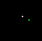

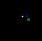

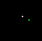

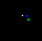

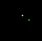

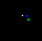

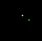

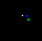

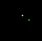

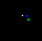

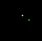

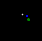

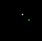

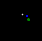

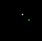

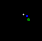

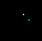

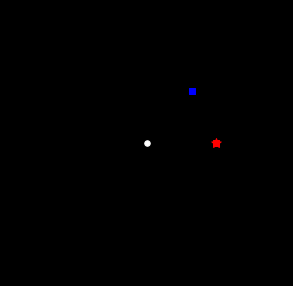

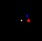

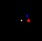

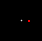

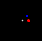

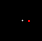

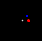

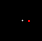

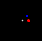

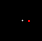

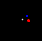

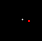

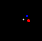

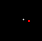

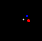

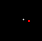

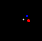

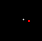

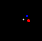

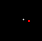

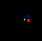

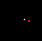

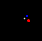

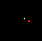

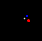

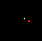

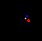

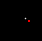

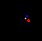

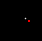

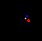

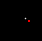

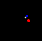

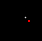

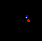

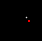

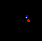

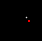

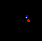

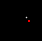

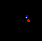

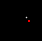

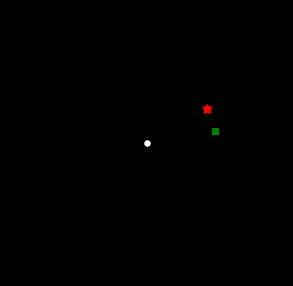

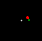

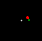

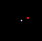

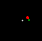

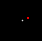

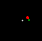

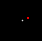

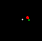

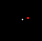

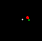

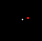

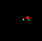

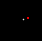

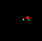

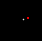

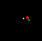

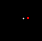

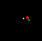

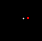

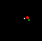

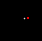

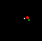

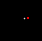

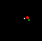

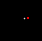

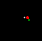

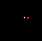

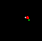

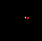

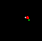

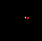

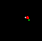

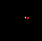

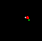

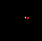

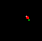

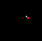

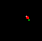

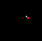

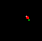

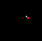

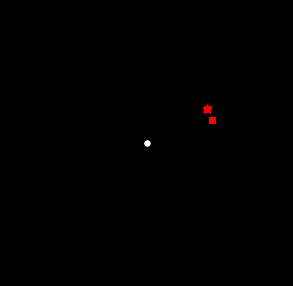

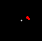

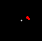

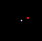

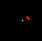

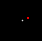

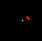

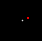

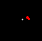

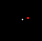

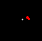

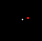

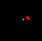

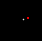

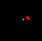

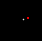

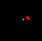

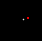

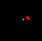

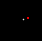

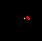

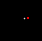

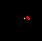

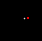

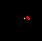

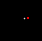

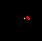

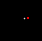

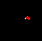

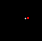

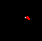

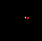

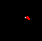

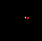

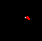

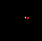

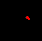

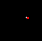

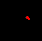

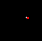

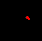

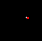

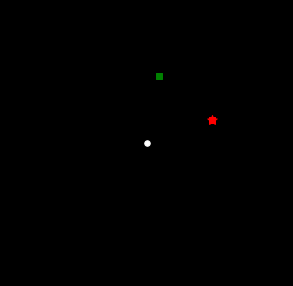

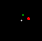

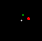

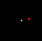

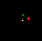

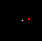

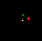

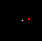

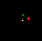

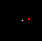

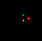

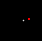

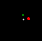

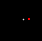

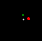

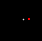

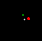

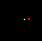

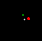

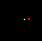

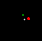

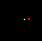

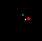

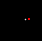

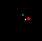

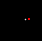

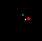

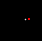

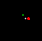

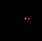

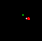

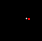

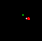

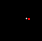

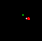

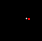

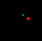

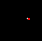

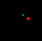

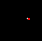

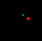

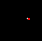

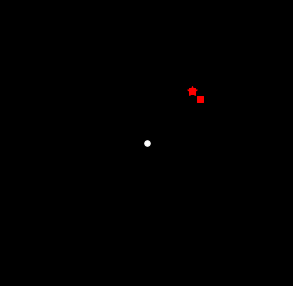

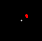

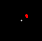

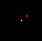

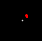

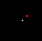

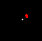

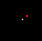

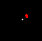

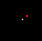

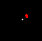

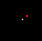

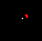

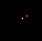

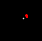

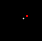

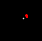

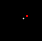

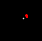

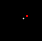

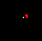

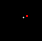

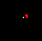

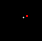

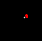

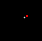

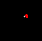

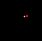

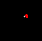

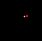

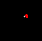

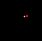

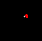

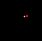

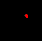

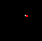

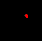

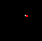

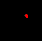

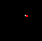

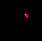

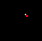

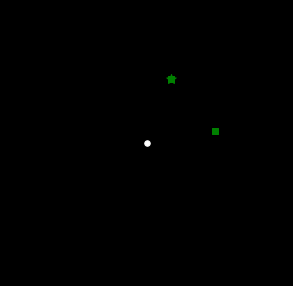

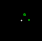

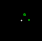

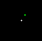

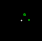

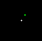

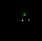

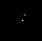

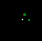

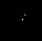

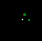

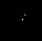

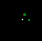

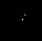

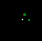

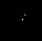

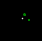

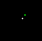

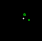

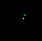

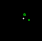

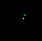

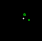

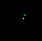

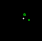

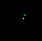

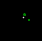

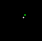

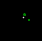

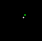

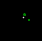

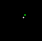

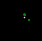

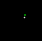

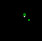

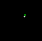

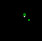

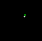

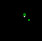

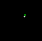

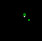

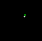

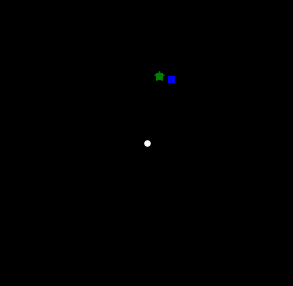

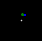

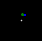

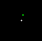

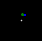

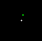

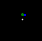

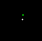

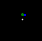

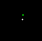

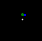

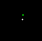

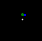

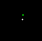

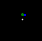

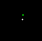

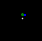

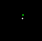

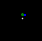

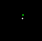

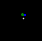

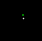

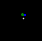

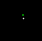

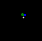

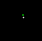

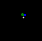

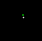

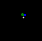

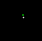

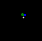

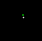

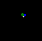

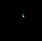

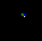

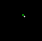

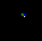

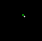

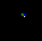

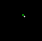

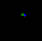

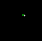

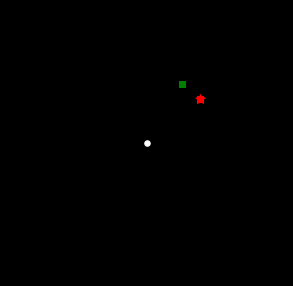

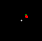

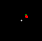

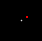

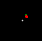

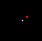

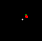

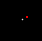

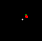

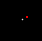

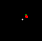

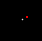

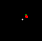

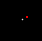

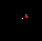

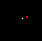

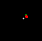

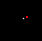

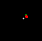

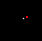

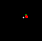

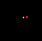

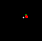

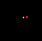

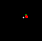

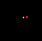

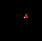

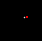

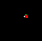

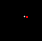

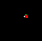

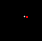

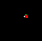

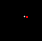

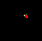

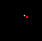

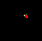

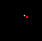

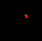

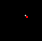

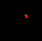

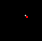

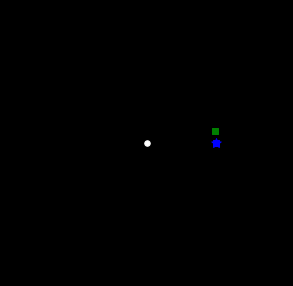

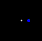

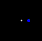

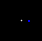

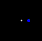

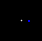

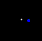

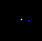

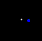

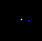

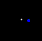

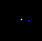

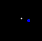

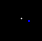

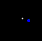

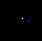

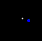

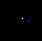

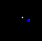

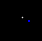

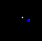

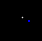

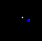

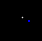

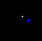

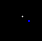

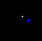

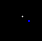

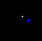

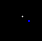

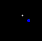

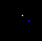

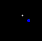

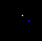

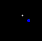

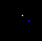

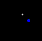

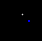

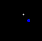

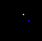

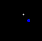

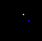

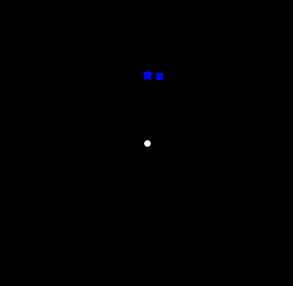

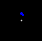

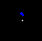

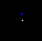

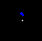

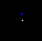

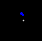

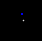

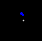

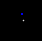

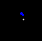

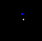

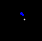

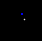

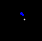

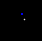

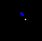

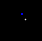

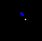

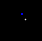

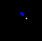

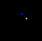

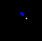

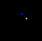

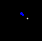

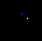

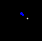

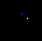

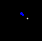

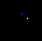

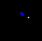

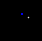

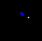

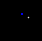

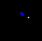

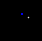

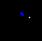

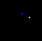

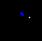

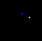

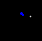

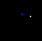

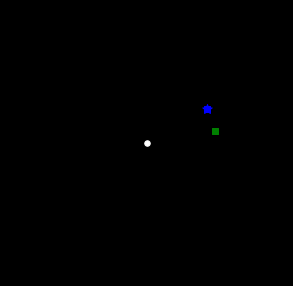

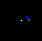

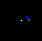

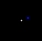

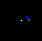

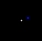

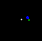

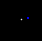

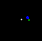

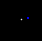

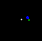

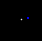

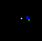

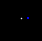

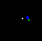

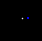

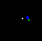

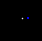

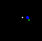

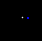

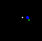

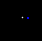

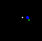

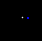

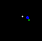

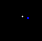

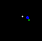

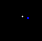

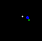

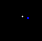

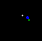

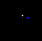

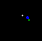

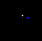

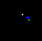

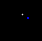

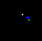

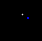

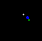

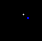

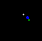

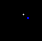

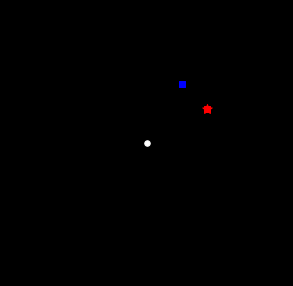

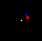

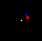

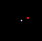

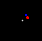

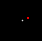

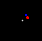

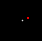

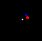

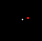

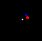

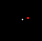

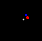

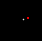

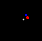

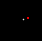

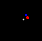

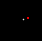

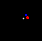

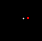

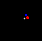

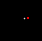

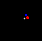

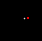

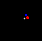

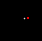

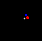

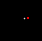

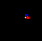

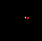

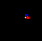

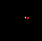

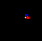

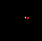

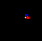

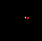

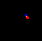

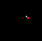

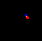

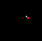

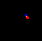

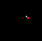

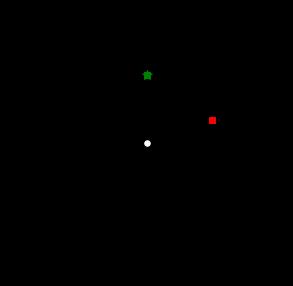

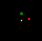

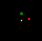

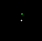

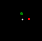

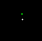

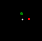

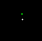

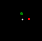

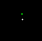

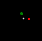

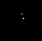

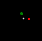

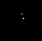

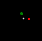

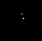

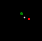

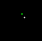

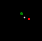

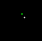

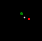

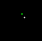

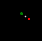

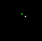

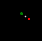

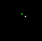

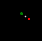

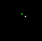

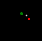

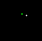

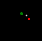

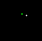

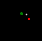

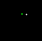

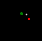

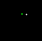

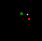

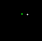

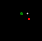

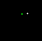

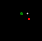

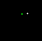

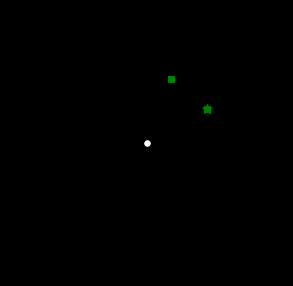

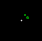

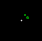

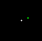

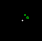

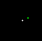

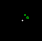

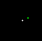

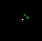

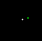

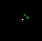

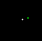

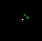

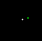

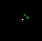

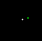

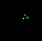

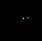

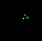

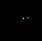

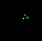

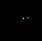

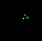

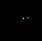

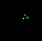

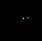

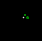

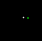

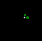

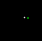

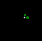

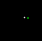

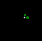

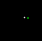

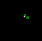

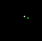

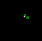

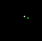

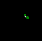

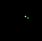

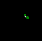

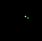

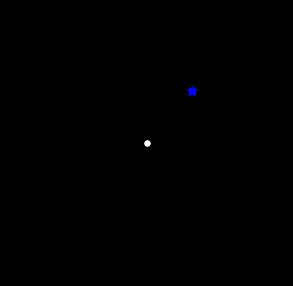

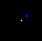

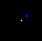

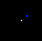

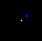

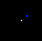

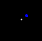

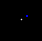

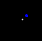

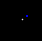

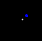

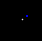

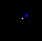

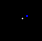

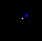

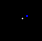

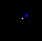

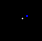

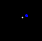

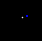

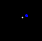

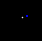

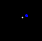

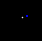

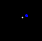

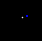

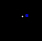

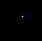

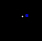

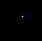

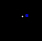

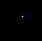

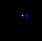

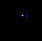

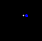

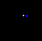

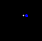

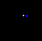

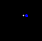

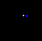

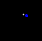

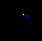

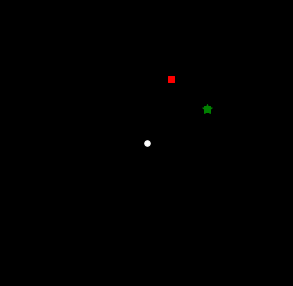

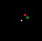

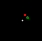

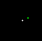

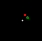

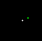

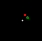

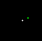

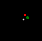

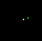

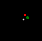

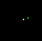

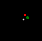

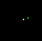

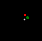

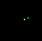

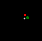

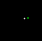

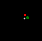

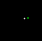

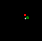

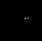

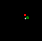

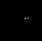

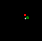

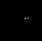

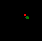

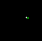

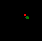

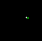

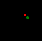

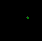

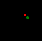

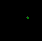

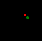

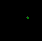

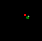

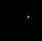

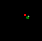

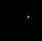

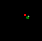

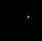

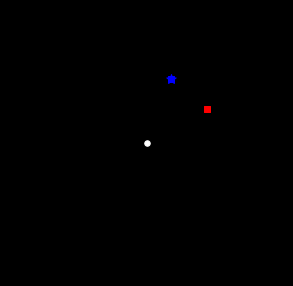

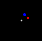

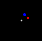

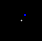

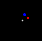

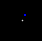

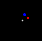

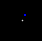

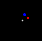

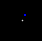

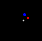

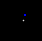

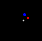

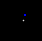

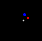

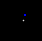

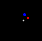

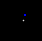

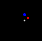

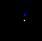

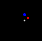

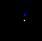

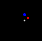

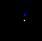

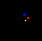

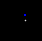

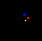

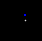

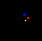

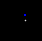

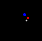

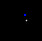

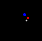

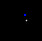

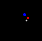

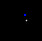

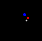

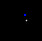

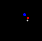

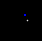

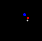

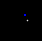

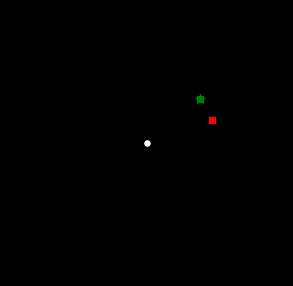

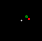

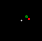

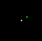

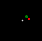

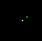

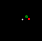

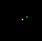

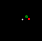

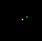

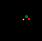

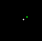

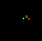

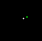

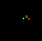

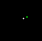

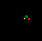

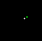

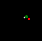

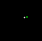

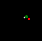

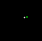

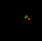

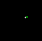

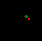

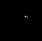

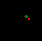

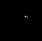

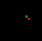

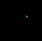

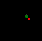

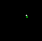

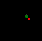

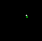

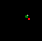

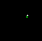

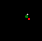

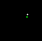

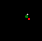

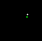

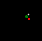

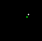

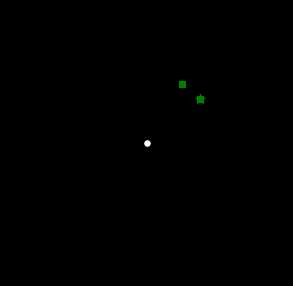

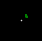

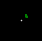

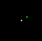

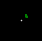

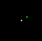

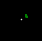

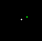

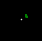

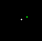

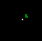

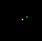

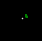

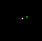

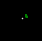

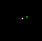

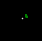

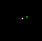

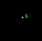

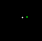

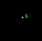

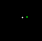

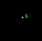

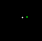

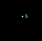

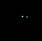

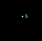

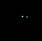

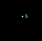

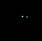

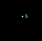

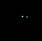

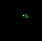

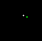

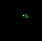

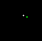

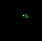

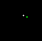

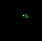

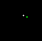

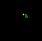

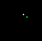

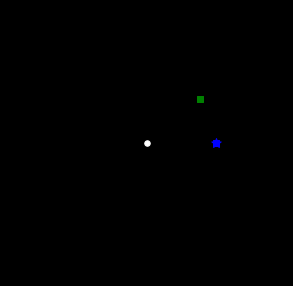

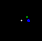

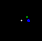

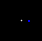

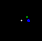

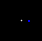

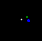

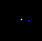

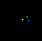

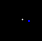

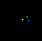

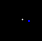

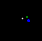

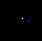

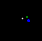

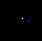

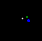

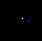

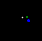

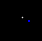

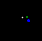

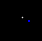

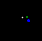

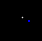

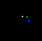

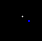

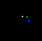

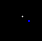

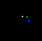

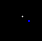

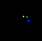

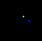

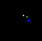

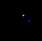

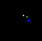

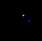

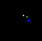

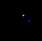

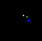

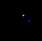

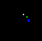

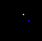

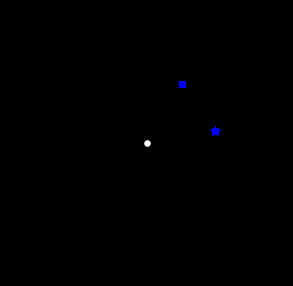

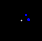

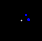

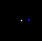

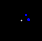

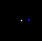

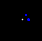

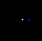

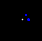

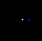

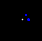

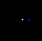

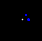

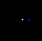

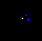

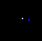

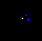

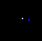

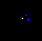

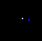

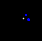

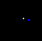

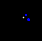

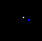

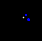

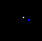

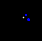

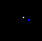

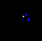

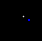

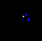

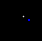

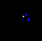

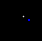

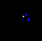

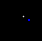

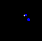

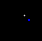

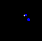

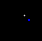

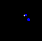

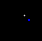

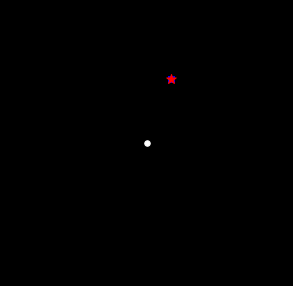

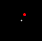

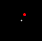

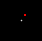

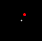

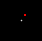

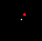

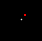

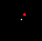

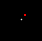

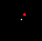

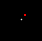

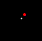

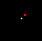

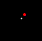

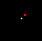

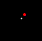

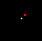

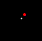

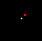

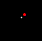

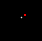

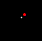

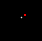

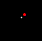

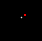

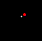

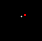

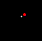

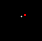

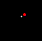

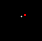

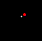

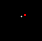

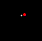

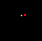

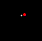

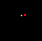

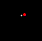

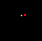

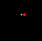

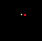

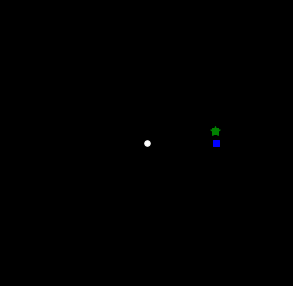

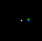

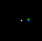

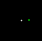

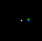

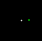

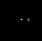

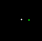

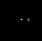

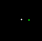

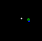

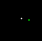

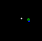

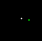

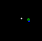

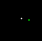

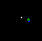

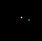

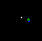

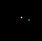

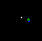

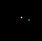

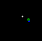

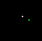

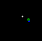

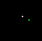

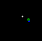

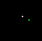

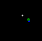

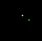

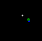

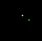

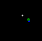

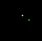

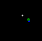

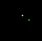

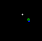

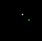

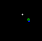

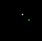

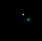

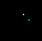

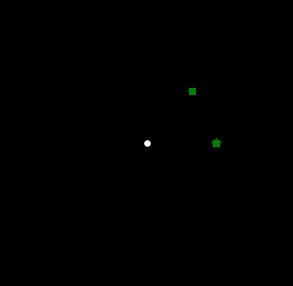

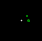

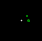

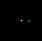

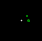

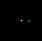

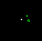

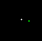

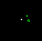

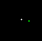

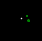

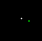

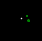

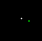

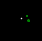

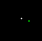

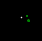

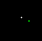

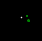

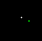

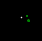

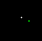

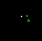

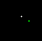

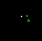

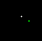

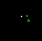

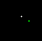

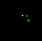

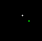

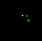

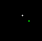

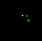

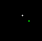

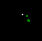

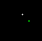

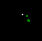

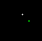

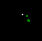

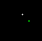

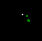

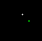

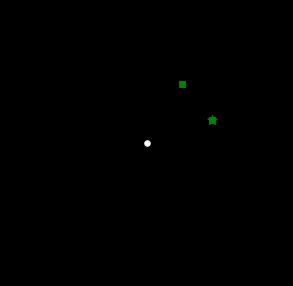

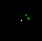

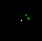

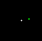

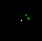

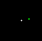

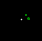

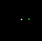

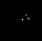

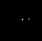

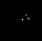

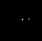

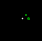

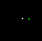

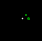

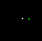

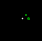

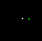

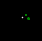

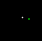

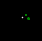

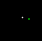

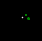

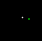

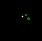

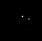

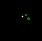

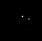

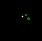

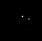

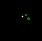

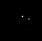

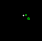

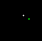

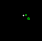

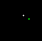

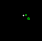

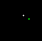

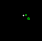

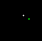

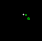

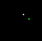

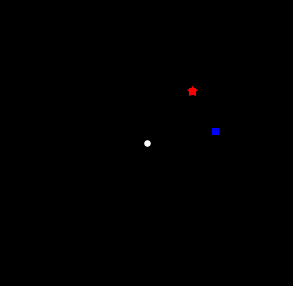

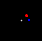

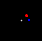

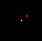

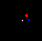

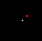

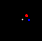

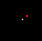

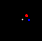

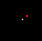

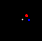

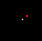

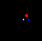

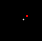

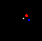

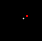

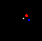

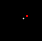

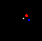

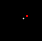

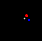

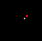

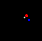

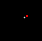

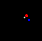

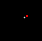

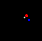

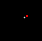

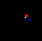

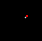

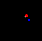

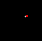

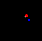

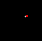

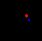

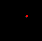

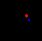

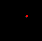

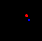

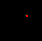

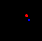

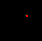

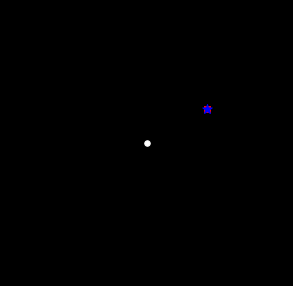

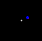

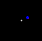

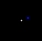

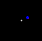

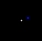

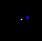

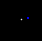

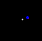

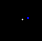

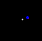

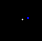

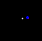

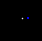

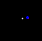

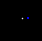

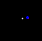

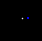

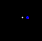

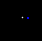

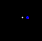

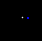

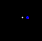

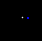

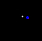

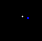

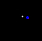

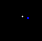

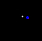

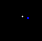

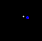

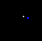

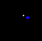

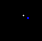

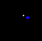

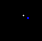

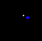

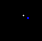

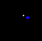

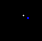

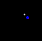

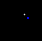

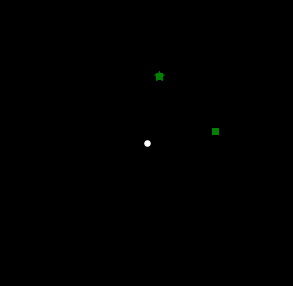

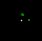

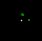

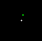

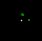

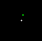

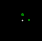

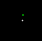

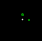

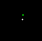

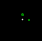

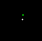

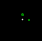

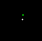

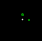

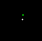

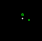

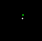

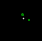

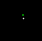

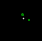

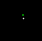

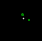

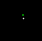

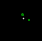

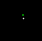

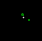

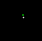

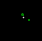

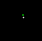

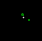

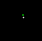

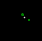

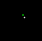

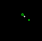

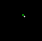

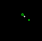

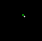

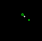

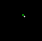

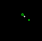

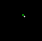

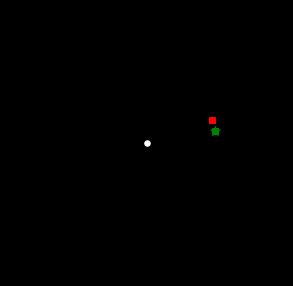

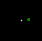

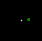

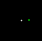

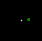

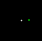

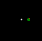

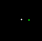

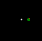

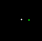

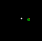

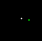

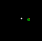

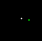

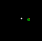

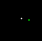

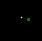

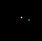

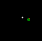

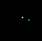

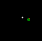

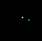

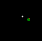

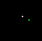

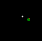

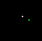

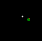

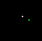

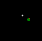

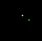

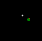

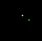

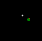

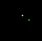

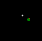

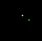

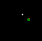

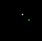

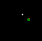

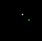

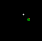

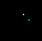

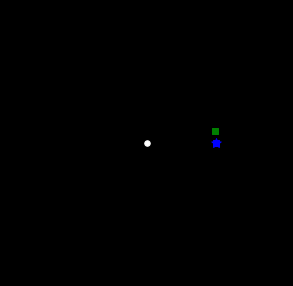

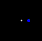

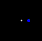

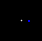

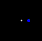

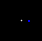

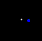

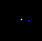

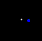

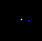

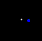

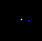

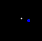

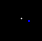

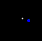

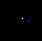

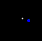

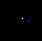

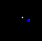

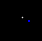

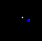

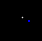

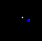

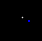

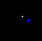

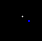

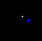

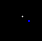

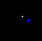

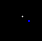

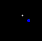

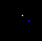

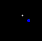

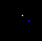

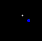

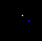

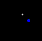

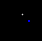

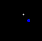

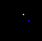

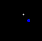

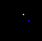

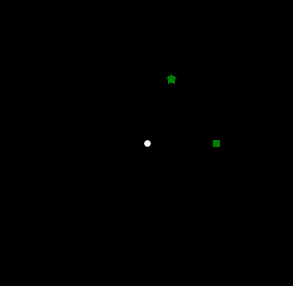

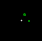

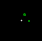

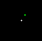

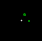

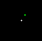

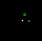

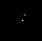

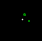

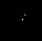

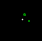

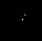

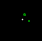

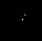

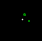

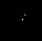

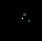

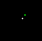

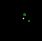

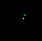

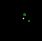

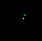

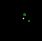

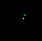

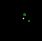

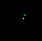

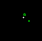

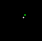

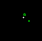

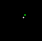

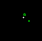

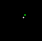

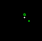

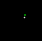

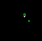

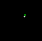

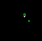

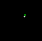

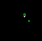

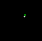

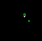

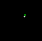

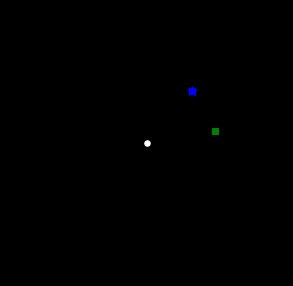

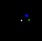

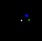

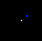

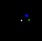

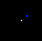

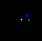

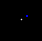

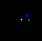

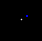

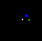

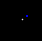

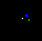

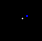

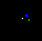

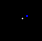

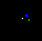

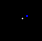

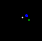

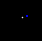

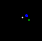

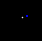

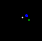

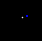

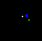

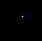

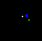

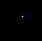

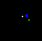

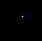

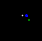

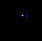

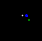

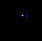

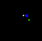

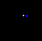

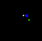

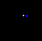

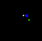

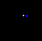

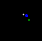

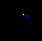

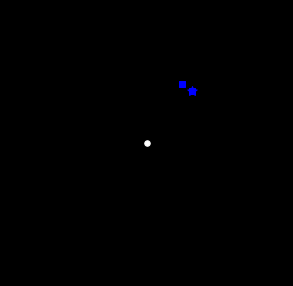

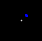

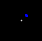

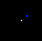

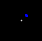

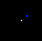

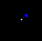

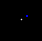

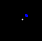

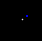

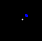

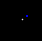

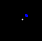

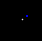

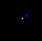

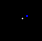

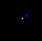

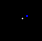

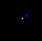

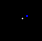

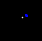

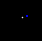

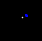

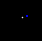

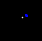

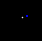

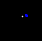

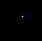

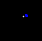

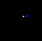

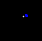

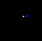

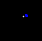

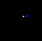

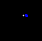

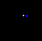

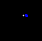

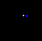

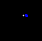

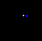

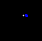

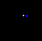

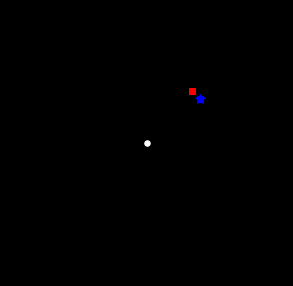

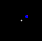

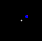

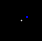

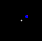

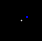

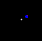

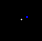

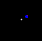

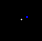

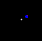

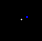

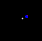

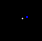

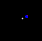

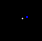

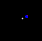

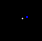

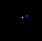

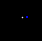

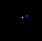

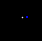

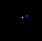

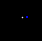

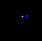

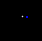

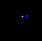

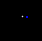

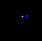

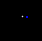

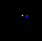

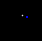

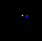

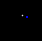

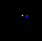

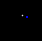

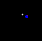

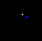

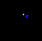

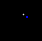

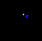

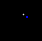

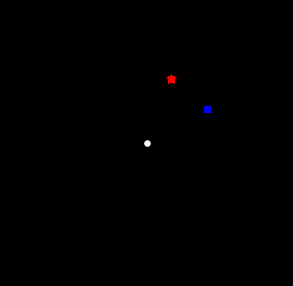

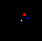

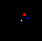

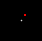

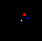

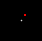

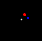

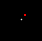

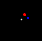

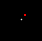

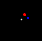

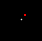

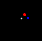

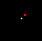

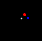

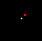

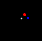

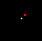

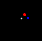

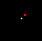

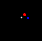

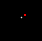

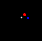

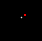

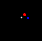

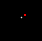

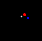

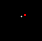

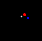

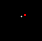

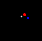

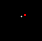

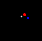

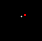

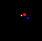

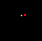

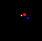

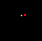

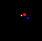

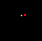

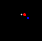

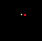

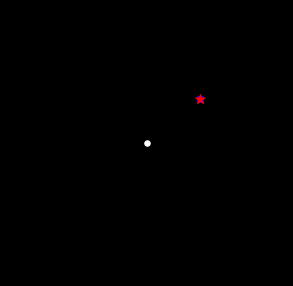

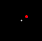

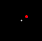

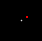

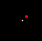

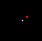

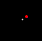

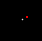

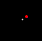

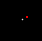

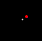

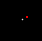

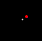

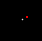

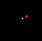

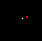

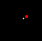

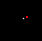

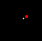

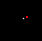

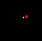

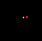

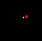

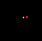

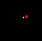

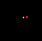

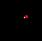

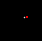

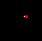

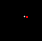

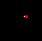

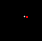

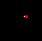

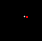

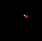

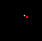

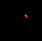

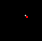

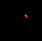

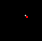

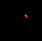

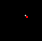

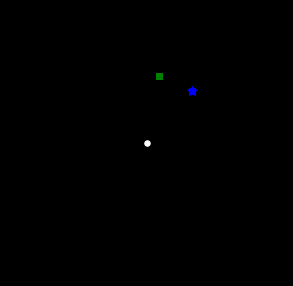

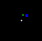

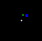

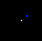

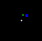

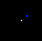

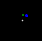

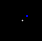

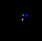

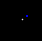

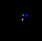

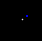

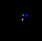

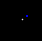

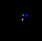

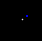

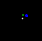

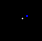

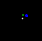

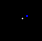

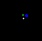

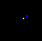

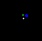

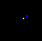

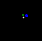

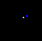

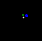

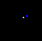

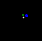

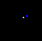

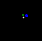

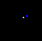

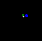

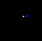

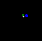

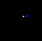

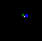

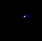

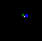

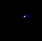

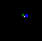

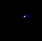

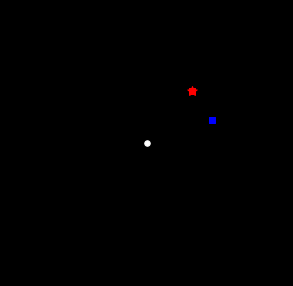

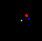

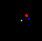

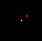

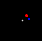

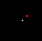

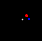

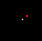

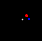

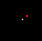

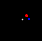

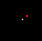

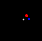

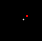

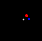

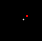

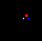

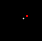

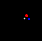

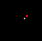

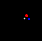

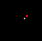

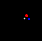

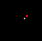

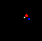

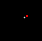

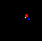

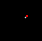

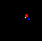

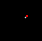

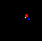

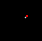

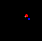

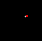

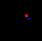

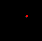

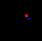

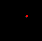

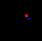

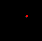

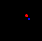

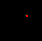

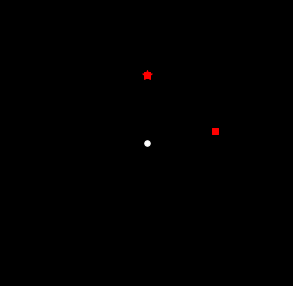

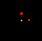

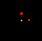

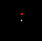

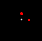

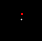

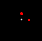

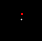

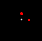

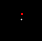

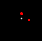

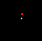

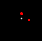

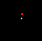

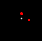

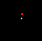

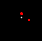

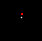

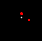

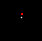

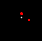

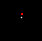

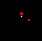

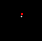

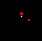

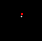

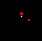

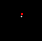

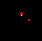

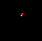

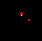

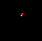

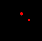

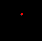

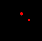

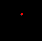

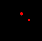

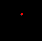

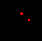

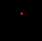

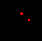

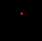

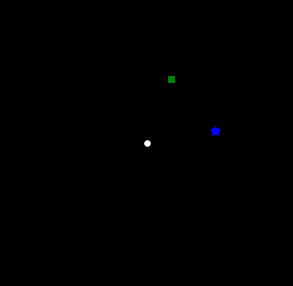

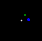

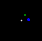

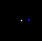

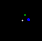

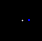

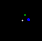

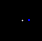

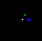

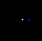

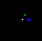

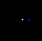

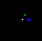

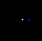

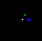

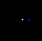

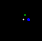

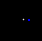

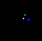

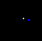

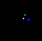

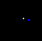

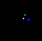

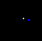

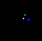

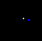

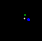

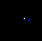

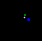

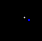

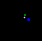

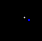

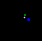

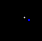

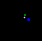

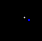

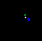

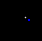

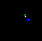

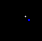

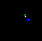

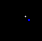

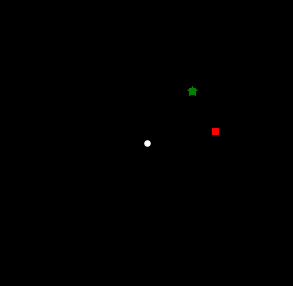

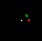

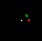

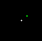

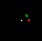

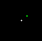

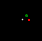

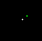

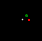

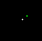

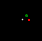

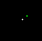

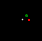

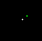

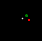

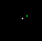

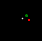

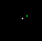

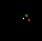

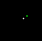

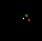

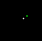

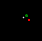

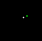

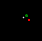

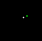

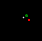

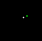

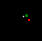

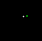

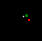

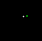

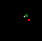

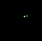

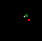

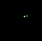

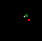

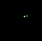

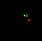

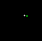

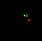

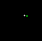

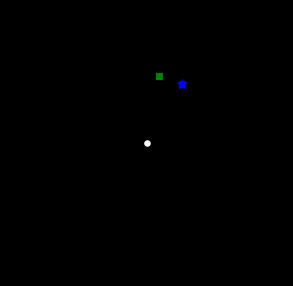

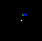

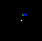

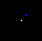

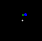

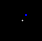

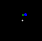

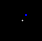

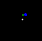

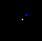

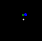

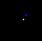

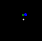

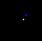

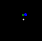

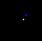

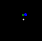

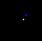

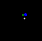

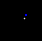

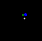

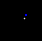

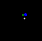

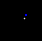

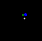

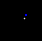

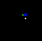

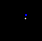

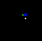

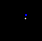

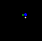

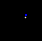

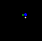

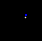

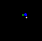

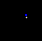

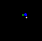

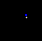

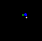

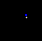

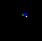

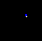

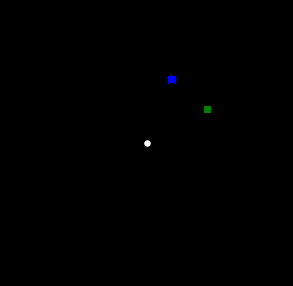

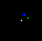

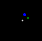

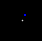

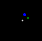

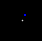

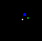

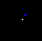

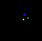

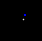

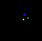

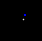

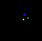

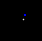

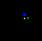

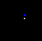

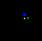

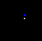

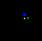

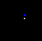

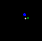

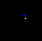

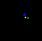

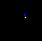

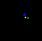

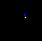

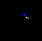

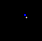

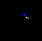

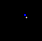

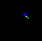

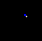

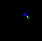

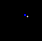

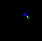

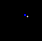

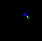

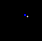

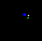

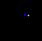

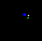

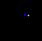

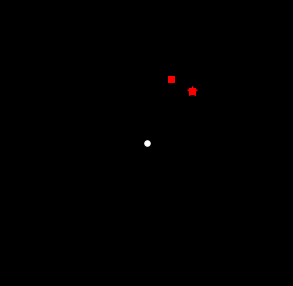

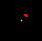

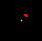

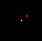

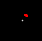

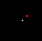

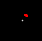

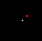

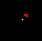

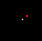

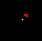

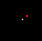

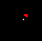

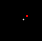

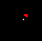

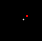

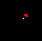

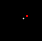

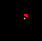

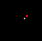

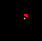

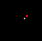

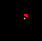

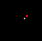

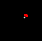

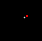

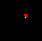

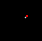

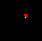

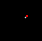

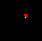

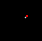

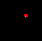

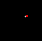

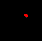

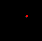

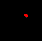

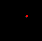

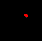

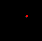

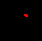

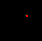

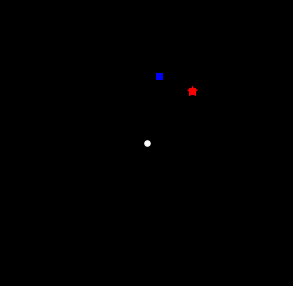

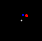

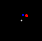

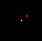

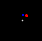

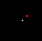

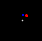

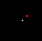

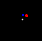

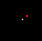

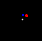

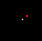

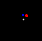

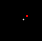

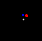

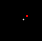

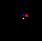

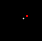

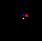

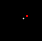

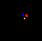

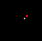

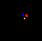

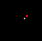

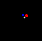

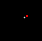

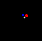

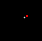

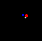

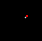

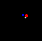

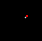

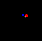

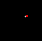

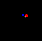

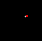

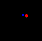

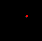

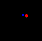

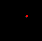

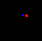

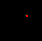

In [274]:
policy.eval()
num_test_trajs = 50
# sets sampling for angles and colors
test_obj_angles = 90
test_obj_colors = [0,1,2]
discretize = 10

dist_to_goals = []
first_state = None
construal = None

for i in range(num_test_trajs):
    env.reset(test_obj_angles, test_obj_colors, discretize)
    plot_env(env)
    goal = torch.Tensor(env.goal_color[None]).to(device)
    #goal = torch.Tensor(lang_model.encode(env.goal)).to(device)
    o = plot_full_state(env.get_full_obs())
    first_state = o.copy()
    #construal = plot_construal(env.get_full_obs()).copy()
    
    traj = {'obs': [],'acts': [], 'true_goal': []}
    for i in range(20):
        state = torch.Tensor(o[None]).to(device)
        if mask:
            action, img_mask , masked_state = policy(goal,state)
            action = action.cpu().detach().numpy()[0]
            img_mask = img_mask.cpu().detach().numpy()[0].transpose(1,2,0)
            masked_state = masked_state.cpu().detach().numpy()[0].transpose(1,2,0)
            if i == 0:
                first_masked_state = masked_state
        else:
            action = policy(goal,state)[0].cpu().detach().numpy()[0]
        no, r, d, _ = env.step(action)
        traj['obs'].append(o.copy())
        traj['acts'].append(action.copy())
        traj['true_goal'].append(env.goal)
        o = plot_full_state(no.copy())
        construal=plot_construal(no.copy())
    traj['obs'] = np.array(traj['obs'])
    traj['acts'] = np.array(traj['acts'])
    traj['true_goal'] = np.array(traj['true_goal'])
    dist_to_goals.append(r.copy())
    #print("Final dist to goal: ", r)
    #plt.plot(traj['obs'][:, 0], traj['obs'][:, 1]) # plots trajs
print("Average dist to goal: ", np.mean(dist_to_goals))
print("Average std: ", np.std(dist_to_goals))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['go to the red square']


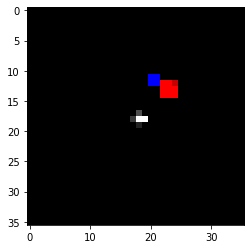

In [275]:
print(env.goal)
plt.imshow(first_masked_state)

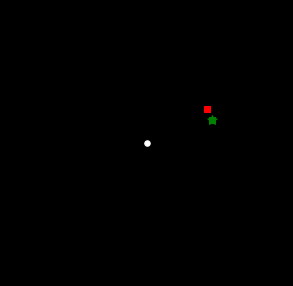

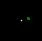

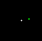

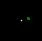

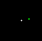

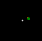

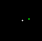

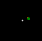

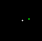

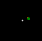

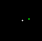

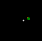

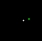

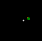

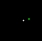

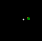

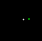

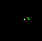

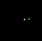

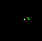

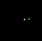

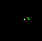

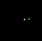

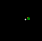

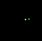

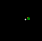

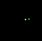

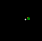

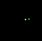

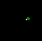

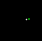

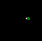

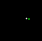

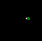

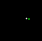

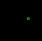

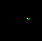

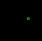

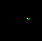

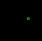

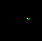

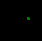

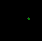

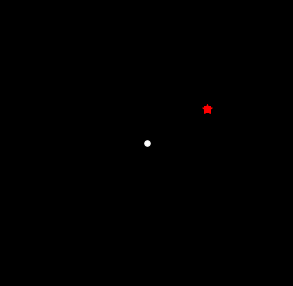

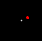

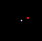

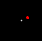

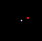

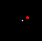

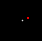

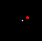

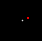

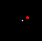

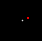

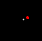

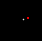

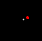

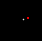

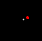

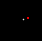

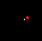

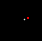

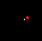

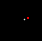

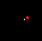

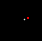

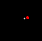

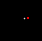

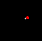

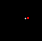

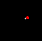

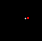

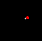

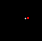

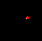

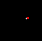

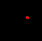

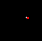

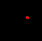

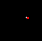

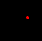

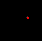

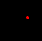

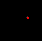

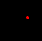

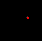

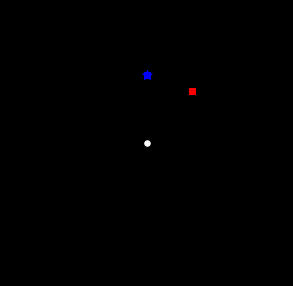

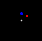

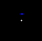

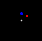

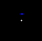

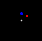

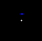

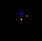

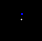

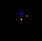

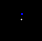

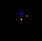

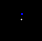

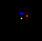

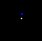

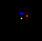

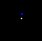

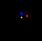

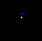

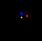

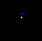

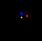

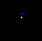

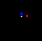

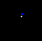

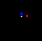

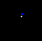

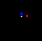

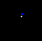

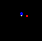

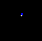

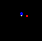

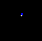

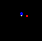

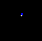

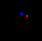

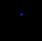

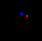

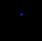

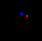

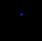

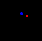

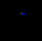

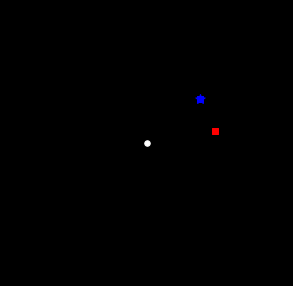

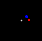

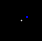

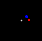

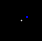

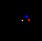

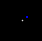

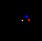

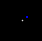

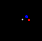

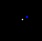

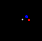

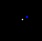

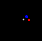

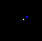

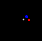

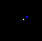

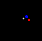

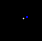

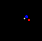

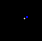

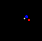

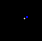

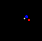

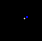

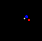

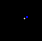

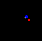

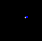

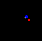

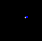

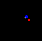

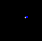

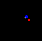

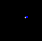

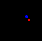

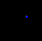

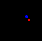

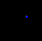

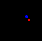

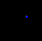

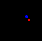

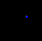

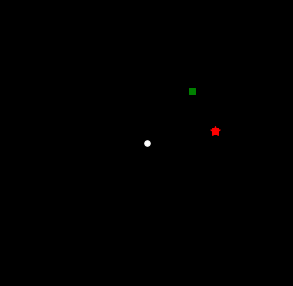

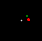

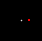

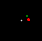

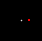

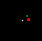

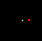

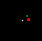

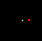

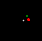

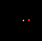

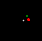

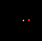

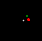

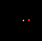

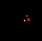

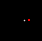

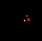

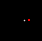

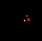

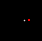

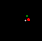

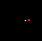

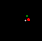

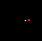

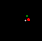

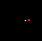

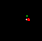

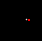

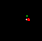

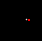

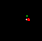

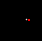

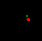

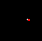

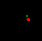

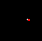

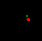

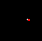

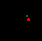

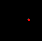

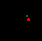

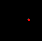

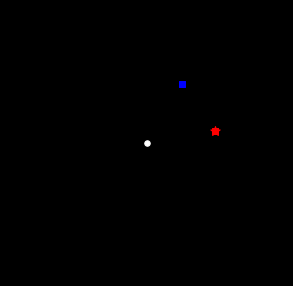

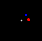

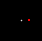

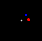

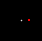

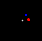

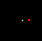

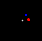

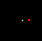

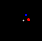

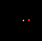

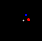

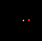

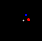

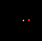

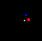

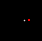

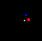

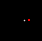

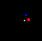

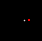

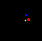

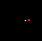

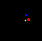

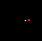

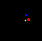

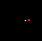

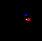

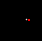

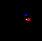

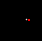

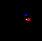

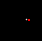

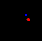

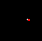

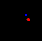

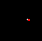

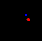

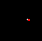

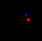

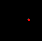

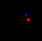

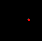

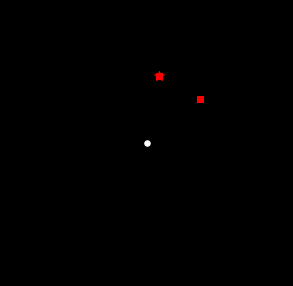

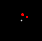

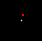

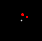

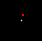

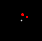

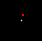

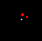

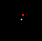

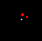

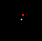

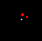

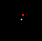

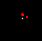

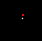

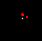

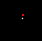

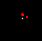

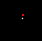

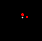

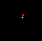

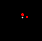

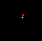

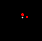

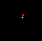

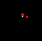

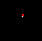

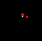

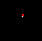

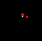

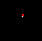

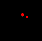

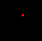

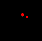

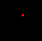

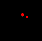

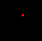

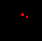

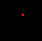

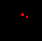

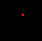

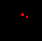

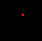

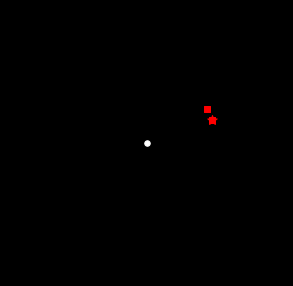

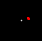

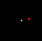

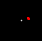

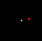

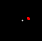

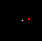

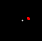

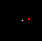

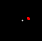

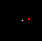

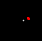

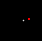

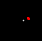

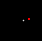

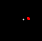

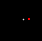

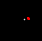

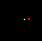

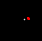

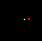

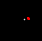

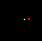

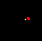

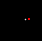

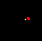

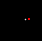

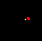

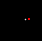

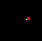

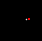

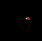

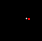

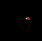

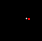

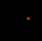

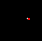

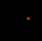

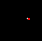

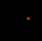

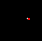

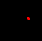

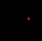

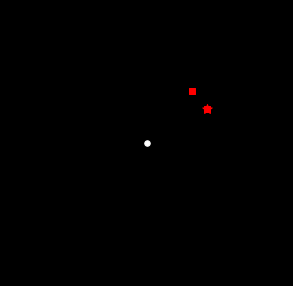

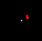

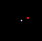

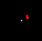

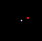

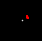

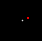

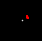

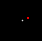

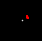

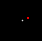

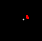

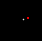

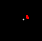

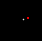

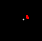

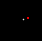

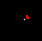

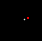

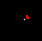

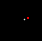

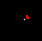

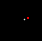

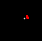

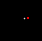

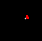

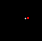

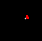

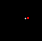

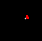

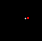

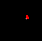

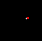

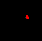

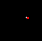

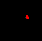

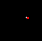

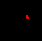

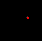

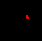

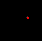

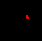

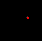

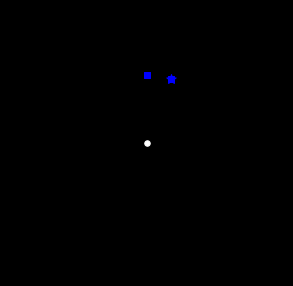

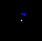

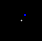

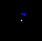

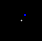

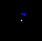

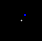

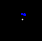

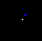

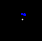

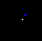

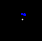

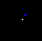

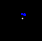

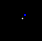

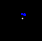

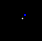

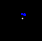

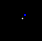

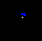

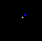

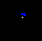

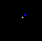

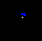

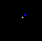

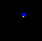

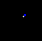

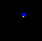

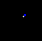

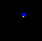

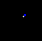

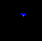

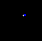

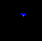

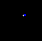

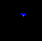

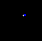

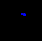

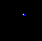

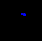

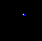

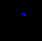

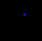

In [279]:
env = PointEnvComplex()
finetune_trajs1 = gen_trajs(env, num_trajs=5, obj_angles=90, obj_colors=[0,1,2], discretize=10)
finetune_trajs2 = gen_trajs(env, num_trajs=5, obj_angles=90, obj_colors=[0,1,2], discretize=10)
finetune_trajs = finetune_trajs1 + finetune_trajs2

[1,     1] loss: 0.12854603
[2,     1] loss: 0.26151782
[3,     1] loss: 0.20923458
[4,     1] loss: 0.26731357
[5,     1] loss: 0.15988570
[6,     1] loss: 0.15220904
[7,     1] loss: 0.16732545
[8,     1] loss: 0.14992145
[9,     1] loss: 0.12039442
[10,     1] loss: 0.11211794
[11,     1] loss: 0.09287323
[12,     1] loss: 0.11869504
[13,     1] loss: 0.10015222
[14,     1] loss: 0.11711316
[15,     1] loss: 0.07953195
[16,     1] loss: 0.12780176
[17,     1] loss: 0.13738398
[18,     1] loss: 0.11705045
[19,     1] loss: 0.10239884
[20,     1] loss: 0.12005165
[21,     1] loss: 0.09785458
[22,     1] loss: 0.08305784
[23,     1] loss: 0.08041273
[24,     1] loss: 0.10263069
[25,     1] loss: 0.09598325
[26,     1] loss: 0.03535612
[27,     1] loss: 0.12072961
[28,     1] loss: 0.10192788
[29,     1] loss: 0.08626935
[30,     1] loss: 0.09667184
[31,     1] loss: 0.10083329
[32,     1] loss: 0.08157021
[33,     1] loss: 0.07405978
[34,     1] loss: 0.15170202
[35,     1] loss: 0.094

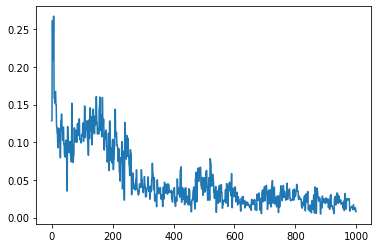

In [280]:
policy_copy = copy.deepcopy(policy)
num_epochs = 500
batch_size = 10

criterion = nn.MSELoss()
optimizer = optim.Adam(list(policy_copy.parameters()))

losses = []

idxs = np.array(range(len(finetune_trajs)))

num_batches = len(idxs) // batch_size
# Train the model with regular SGD
for epoch in range(num_epochs):  # loop over the dataset multiple times
    np.random.shuffle(idxs)
    running_loss = 0.0
    for i in range(num_batches):
        optimizer.zero_grad()

        t1_idx = np.random.randint(len(finetune_trajs), size=(batch_size,)) # Indices of traj
        t1_idx_pertraj = np.random.randint(20, size=(batch_size,)) # Indices of timesteps in traj
        t1_states = np.concatenate([finetune_trajs[c_idx]['obs'][t_idx][None] for (c_idx, t_idx) in zip(t1_idx, t1_idx_pertraj)])
        t1_goals = np.concatenate([finetune_trajs[c_idx]['goal'][t_idx][None] for (c_idx, t_idx) in zip(t1_idx, t1_idx_pertraj)])
        t1_actions = np.concatenate([finetune_trajs[c_idx]['acts'][t_idx][None] for (c_idx, t_idx) in zip(t1_idx, t1_idx_pertraj)])
   
        t1_states = torch.Tensor(t1_states).float().to(device)
        t1_goals = torch.Tensor(t1_goals).float().to(device)
        #t1_goals = torch.Tensor(lang_model.encode(t1_goals.ravel())).float().to(device) # embeds goal through language model dim:384
        t1_actions = torch.Tensor(t1_actions).float().to(device)
        
        if mask:
            a1_preds, state_mask_preds, _= policy_copy(t1_goals, t1_states)
            mask_loss = 1e-4*state_mask_preds.sum()
        else:
            a1_preds = policy_copy(t1_goals, t1_states)[0]
            mask_loss = 0
        
        action_loss = torch.mean(torch.linalg.norm(a1_preds - t1_actions, dim=-1)) # supervised learning loss
        #construal_loss = 1e-1*((state_mask_preds - t1_construals)*(state_mask_preds - t1_construals)).sum() # MSE supervised construal loss
        loss = action_loss + mask_loss #+ construal_loss
        
        loss.backward()
        #print(policy.conv[0].weight.grad)
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 0:
            print('[%d, %5d] loss: %.8f' %
                  (epoch + 1, i + 1, running_loss))
            #print('[%d, %5d] mask loss: %.8f' %
                  #(epoch + 1, i + 1, mask_loss))
            #print('[%d, %5d] action loss: %.8f' %
                  #(epoch + 1, i + 1, supervised_loss))
            losses.append(running_loss)
            running_loss = 0.0
        losses.append(loss.item())

print('Finished Training')
plt.plot(losses)

Average dist to goal:  -1.625812037934811
Average std:  1.3010545905829605


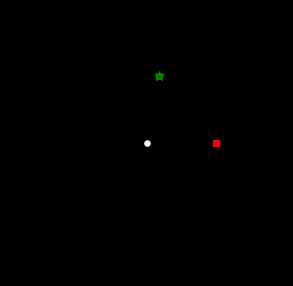

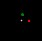

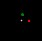

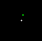

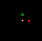

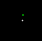

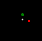

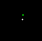

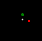

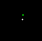

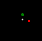

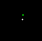

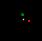

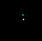

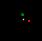

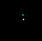

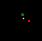

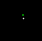

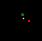

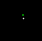

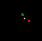

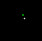

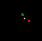

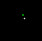

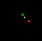

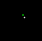

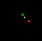

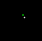

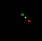

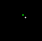

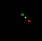

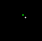

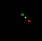

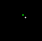

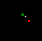

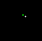

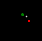

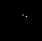

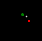

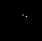

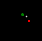

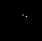

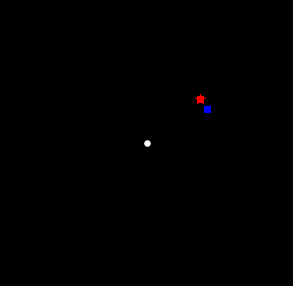

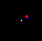

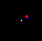

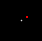

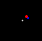

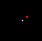

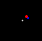

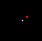

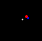

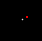

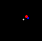

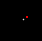

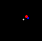

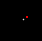

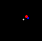

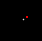

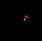

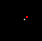

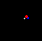

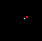

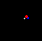

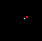

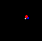

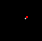

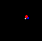

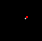

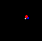

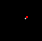

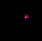

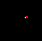

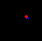

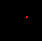

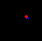

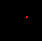

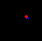

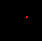

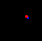

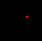

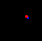

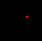

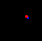

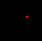

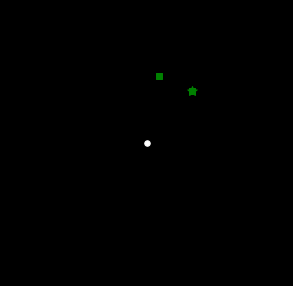

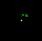

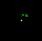

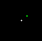

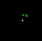

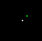

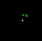

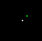

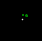

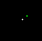

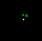

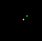

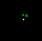

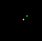

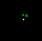

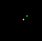

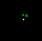

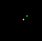

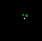

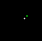

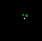

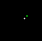

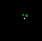

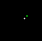

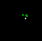

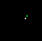

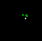

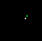

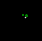

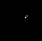

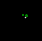

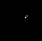

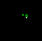

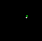

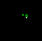

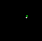

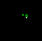

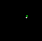

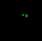

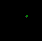

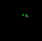

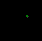

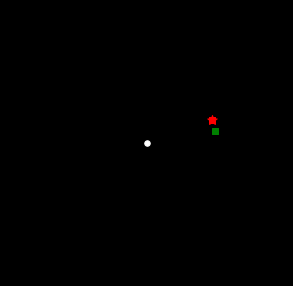

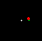

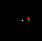

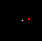

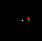

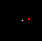

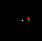

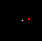

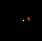

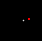

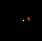

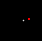

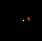

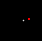

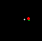

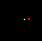

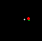

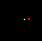

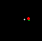

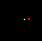

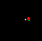

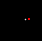

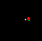

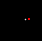

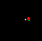

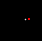

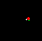

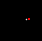

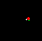

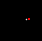

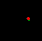

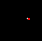

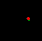

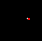

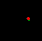

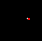

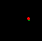

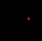

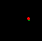

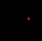

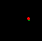

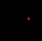

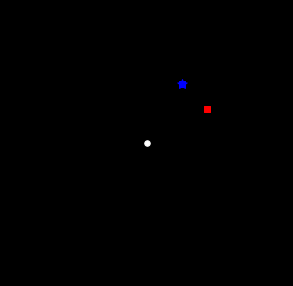

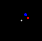

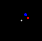

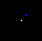

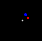

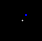

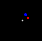

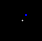

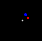

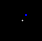

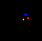

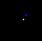

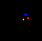

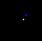

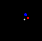

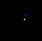

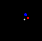

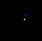

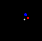

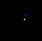

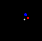

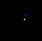

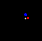

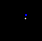

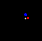

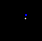

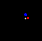

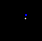

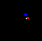

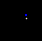

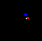

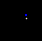

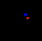

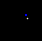

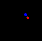

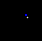

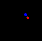

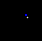

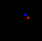

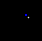

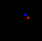

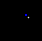

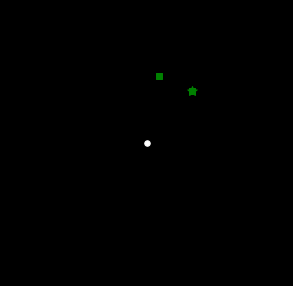

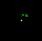

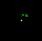

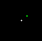

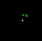

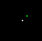

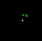

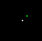

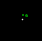

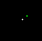

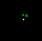

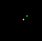

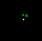

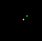

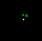

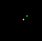

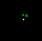

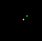

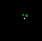

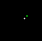

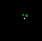

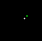

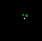

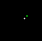

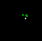

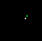

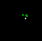

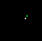

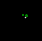

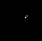

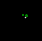

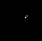

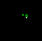

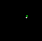

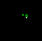

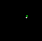

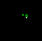

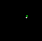

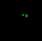

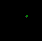

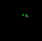

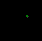

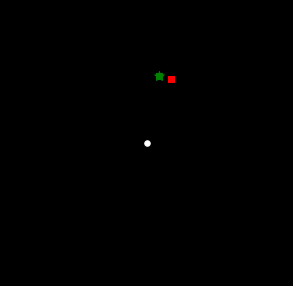

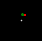

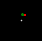

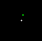

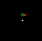

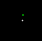

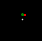

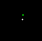

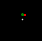

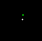

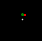

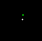

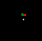

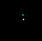

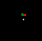

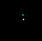

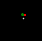

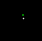

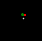

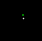

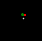

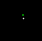

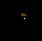

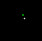

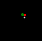

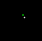

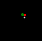

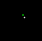

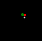

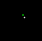

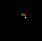

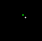

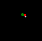

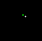

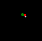

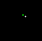

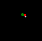

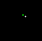

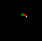

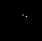

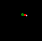

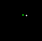

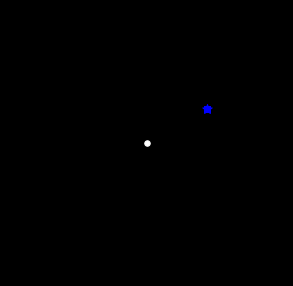

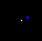

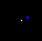

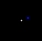

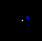

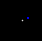

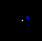

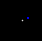

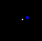

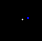

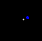

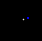

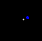

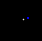

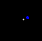

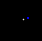

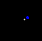

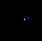

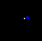

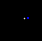

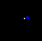

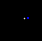

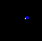

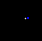

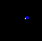

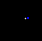

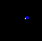

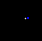

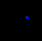

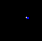

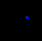

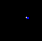

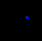

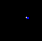

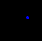

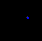

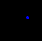

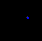

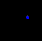

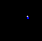

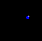

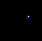

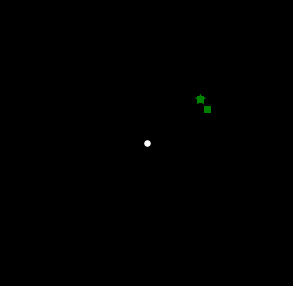

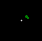

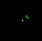

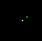

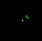

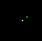

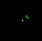

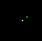

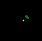

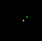

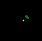

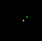

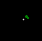

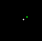

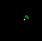

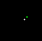

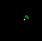

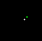

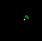

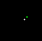

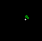

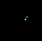

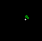

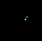

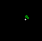

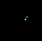

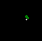

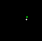

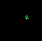

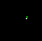

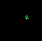

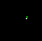

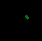

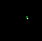

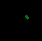

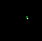

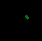

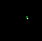

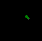

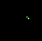

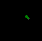

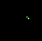

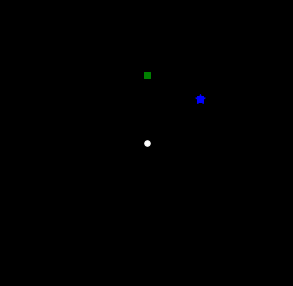

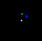

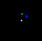

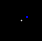

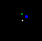

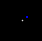

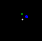

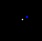

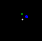

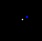

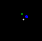

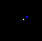

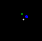

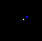

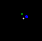

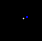

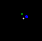

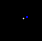

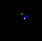

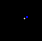

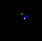

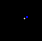

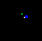

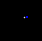

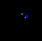

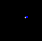

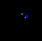

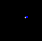

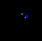

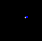

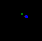

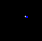

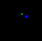

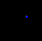

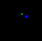

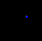

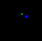

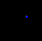

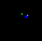

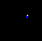

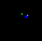

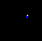

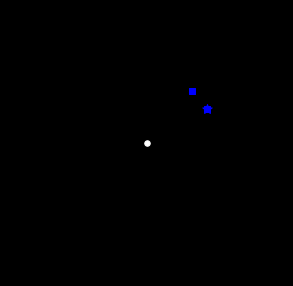

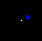

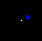

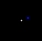

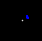

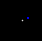

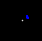

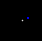

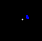

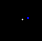

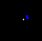

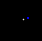

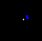

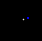

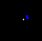

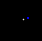

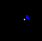

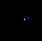

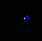

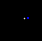

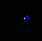

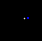

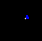

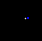

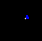

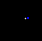

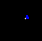

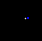

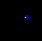

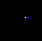

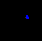

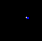

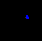

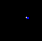

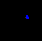

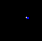

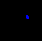

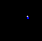

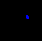

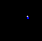

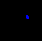

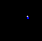

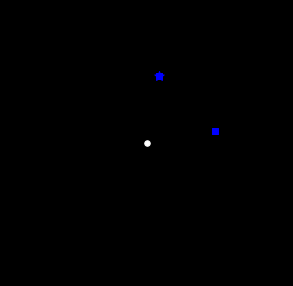

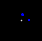

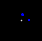

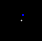

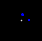

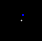

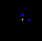

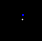

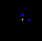

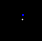

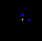

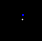

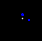

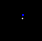

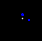

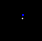

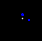

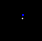

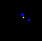

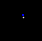

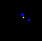

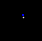

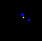

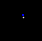

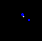

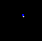

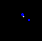

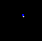

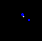

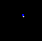

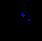

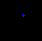

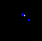

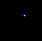

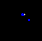

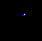

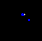

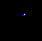

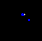

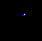

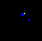

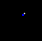

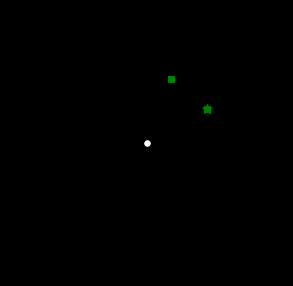

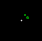

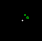

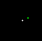

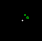

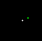

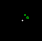

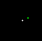

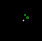

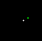

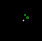

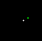

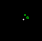

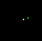

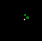

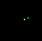

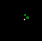

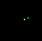

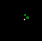

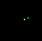

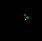

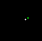

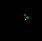

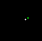

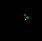

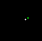

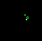

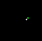

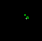

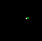

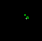

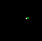

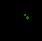

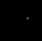

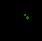

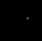

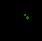

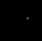

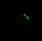

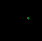

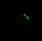

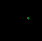

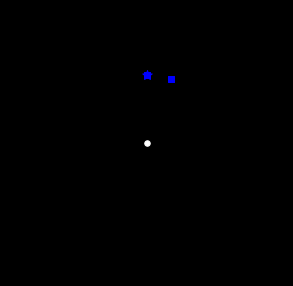

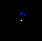

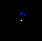

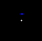

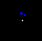

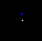

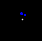

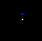

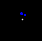

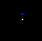

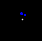

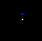

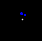

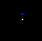

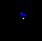

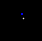

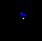

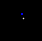

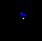

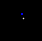

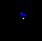

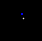

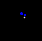

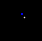

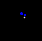

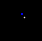

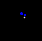

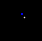

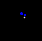

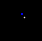

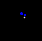

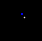

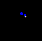

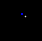

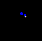

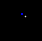

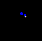

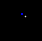

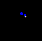

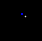

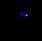

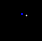

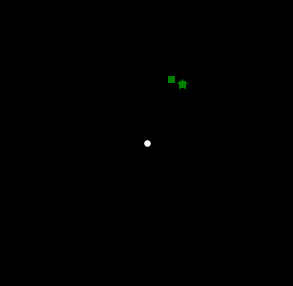

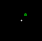

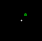

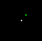

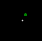

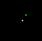

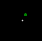

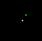

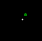

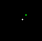

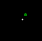

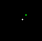

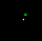

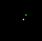

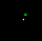

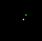

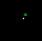

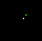

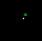

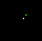

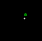

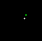

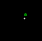

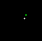

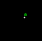

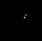

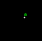

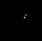

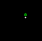

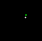

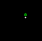

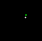

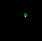

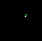

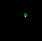

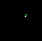

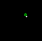

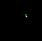

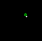

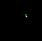

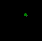

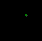

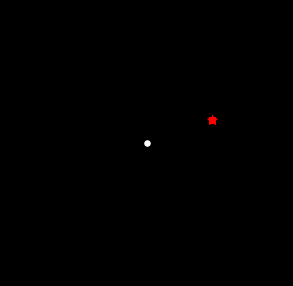

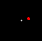

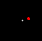

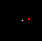

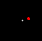

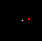

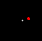

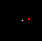

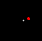

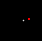

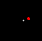

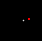

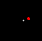

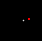

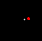

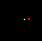

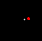

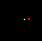

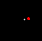

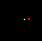

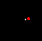

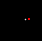

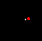

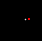

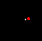

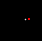

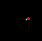

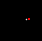

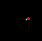

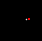

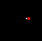

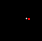

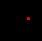

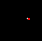

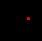

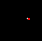

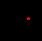

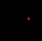

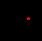

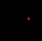

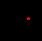

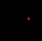

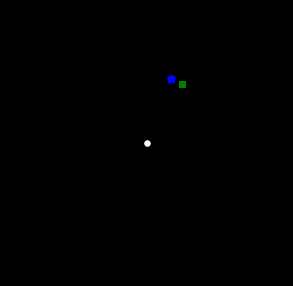

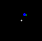

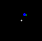

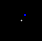

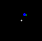

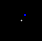

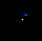

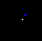

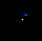

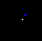

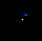

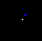

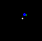

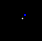

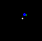

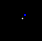

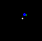

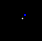

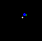

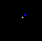

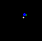

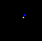

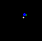

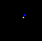

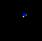

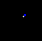

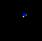

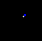

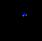

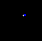

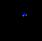

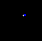

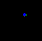

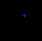

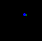

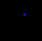

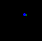

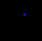

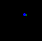

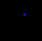

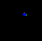

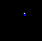

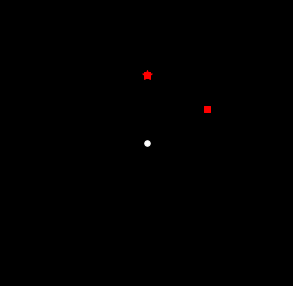

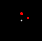

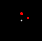

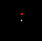

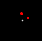

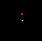

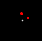

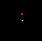

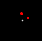

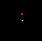

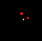

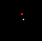

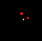

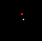

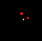

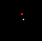

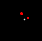

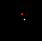

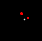

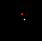

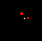

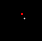

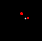

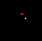

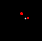

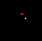

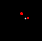

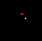

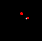

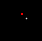

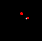

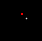

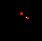

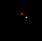

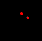

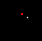

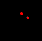

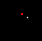

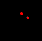

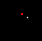

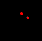

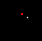

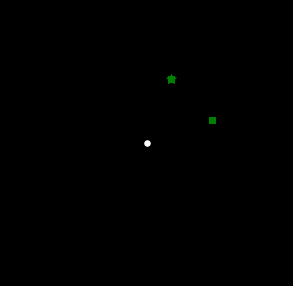

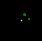

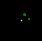

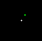

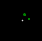

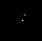

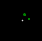

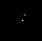

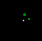

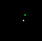

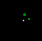

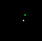

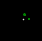

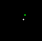

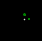

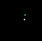

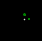

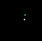

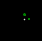

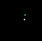

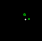

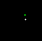

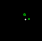

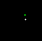

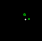

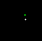

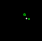

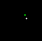

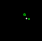

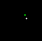

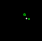

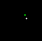

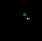

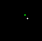

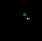

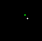

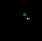

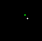

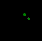

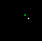

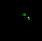

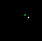

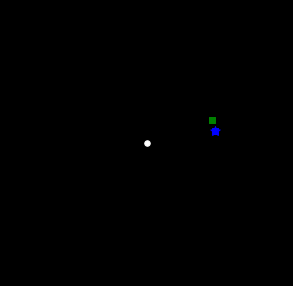

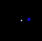

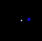

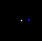

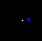

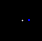

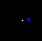

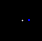

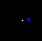

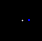

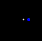

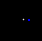

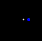

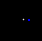

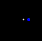

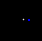

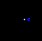

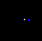

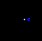

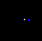

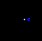

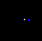

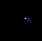

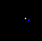

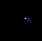

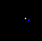

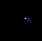

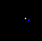

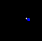

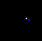

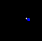

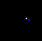

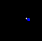

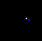

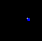

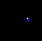

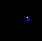

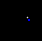

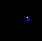

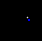

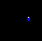

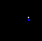

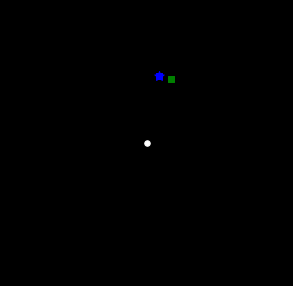

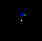

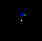

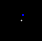

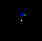

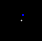

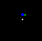

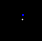

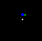

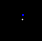

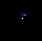

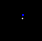

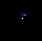

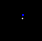

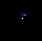

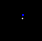

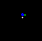

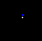

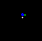

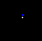

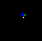

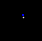

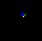

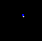

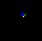

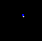

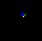

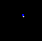

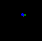

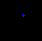

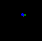

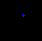

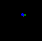

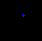

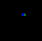

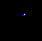

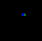

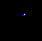

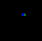

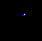

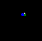

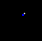

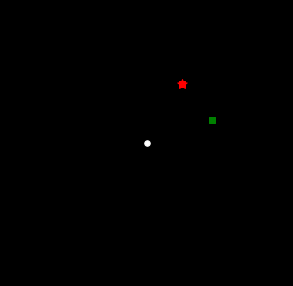

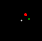

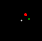

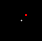

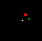

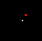

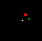

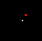

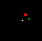

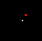

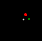

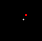

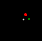

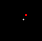

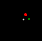

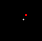

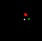

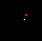

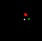

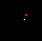

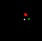

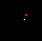

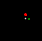

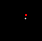

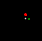

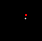

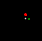

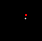

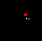

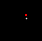

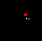

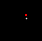

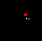

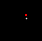

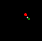

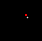

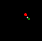

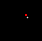

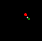

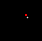

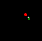

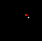

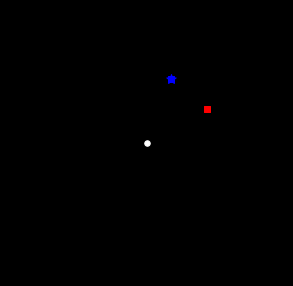

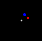

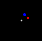

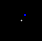

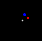

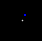

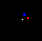

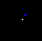

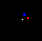

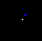

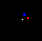

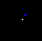

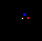

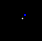

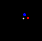

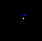

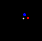

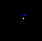

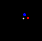

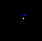

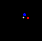

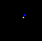

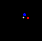

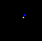

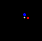

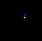

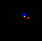

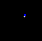

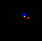

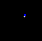

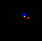

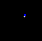

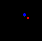

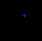

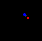

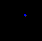

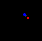

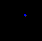

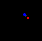

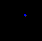

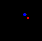

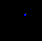

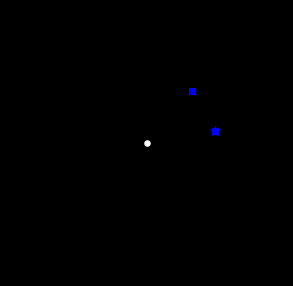

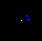

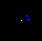

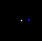

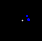

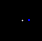

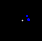

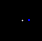

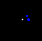

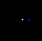

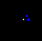

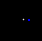

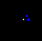

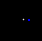

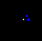

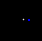

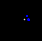

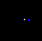

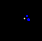

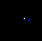

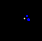

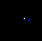

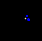

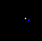

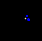

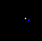

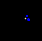

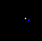

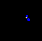

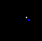

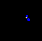

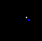

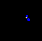

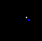

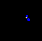

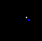

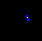

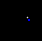

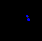

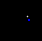

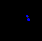

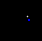

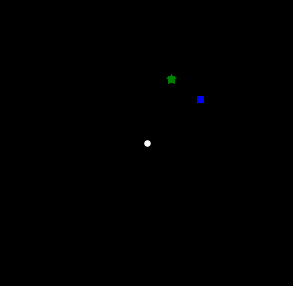

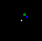

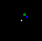

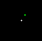

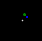

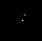

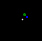

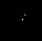

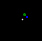

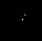

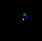

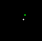

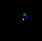

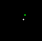

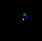

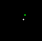

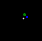

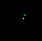

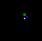

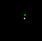

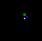

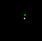

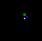

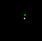

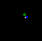

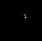

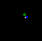

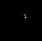

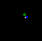

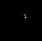

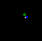

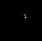

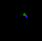

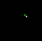

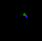

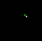

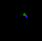

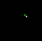

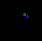

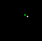

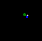

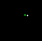

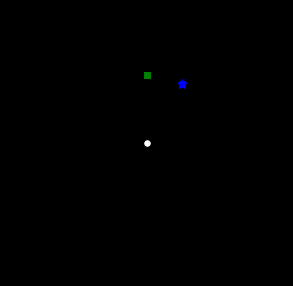

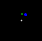

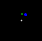

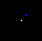

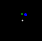

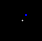

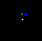

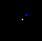

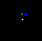

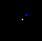

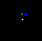

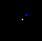

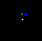

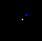

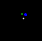

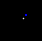

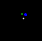

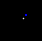

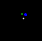

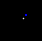

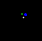

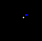

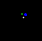

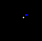

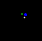

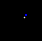

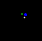

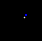

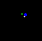

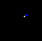

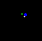

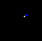

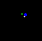

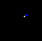

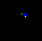

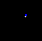

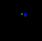

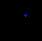

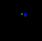

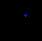

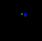

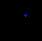

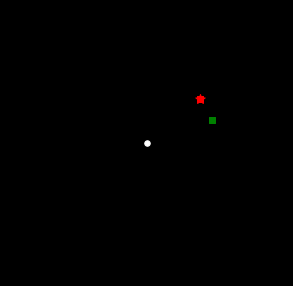

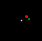

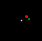

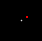

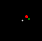

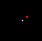

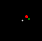

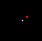

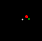

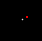

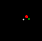

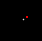

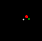

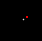

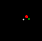

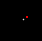

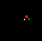

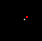

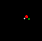

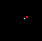

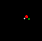

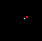

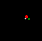

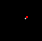

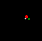

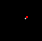

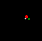

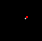

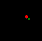

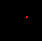

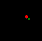

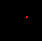

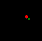

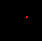

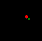

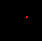

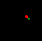

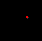

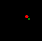

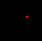

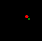

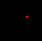

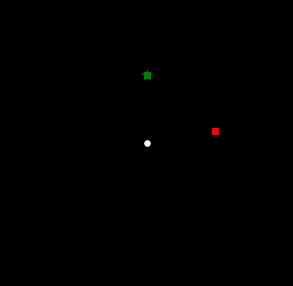

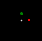

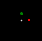

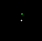

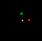

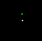

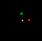

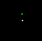

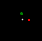

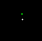

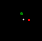

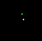

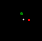

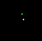

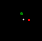

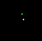

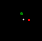

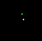

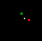

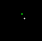

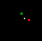

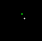

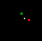

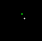

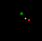

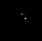

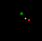

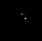

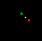

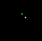

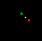

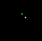

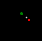

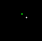

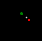

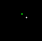

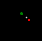

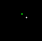

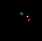

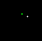

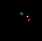

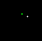

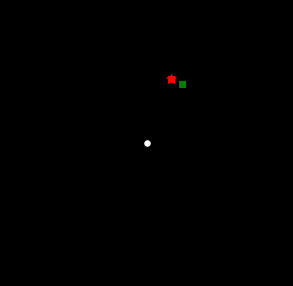

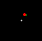

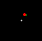

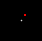

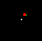

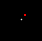

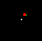

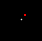

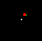

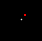

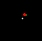

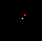

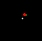

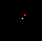

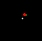

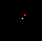

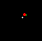

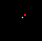

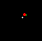

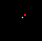

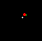

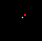

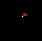

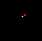

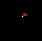

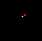

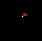

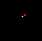

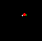

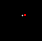

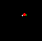

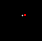

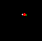

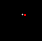

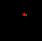

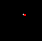

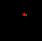

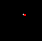

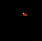

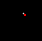

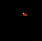

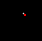

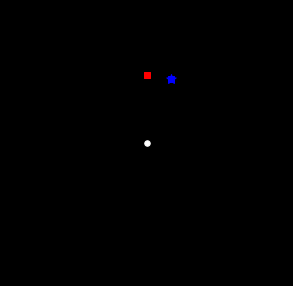

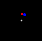

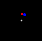

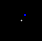

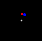

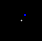

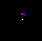

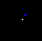

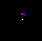

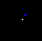

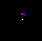

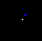

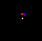

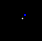

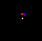

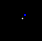

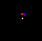

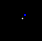

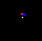

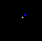

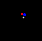

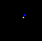

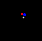

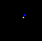

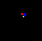

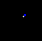

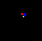

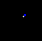

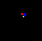

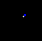

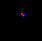

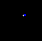

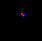

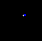

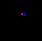

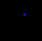

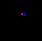

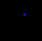

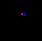

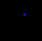

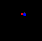

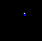

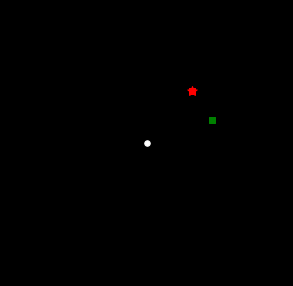

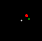

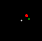

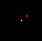

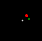

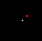

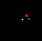

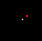

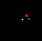

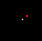

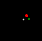

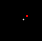

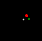

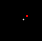

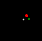

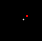

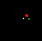

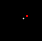

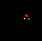

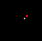

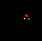

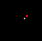

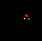

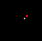

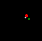

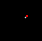

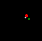

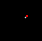

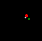

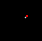

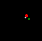

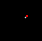

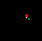

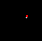

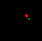

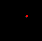

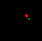

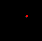

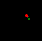

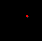

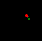

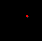

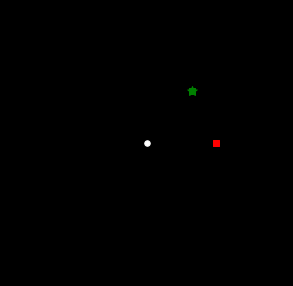

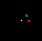

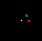

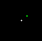

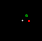

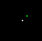

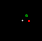

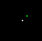

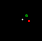

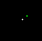

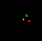

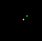

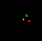

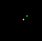

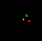

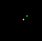

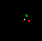

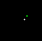

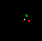

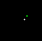

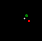

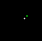

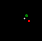

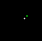

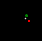

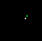

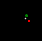

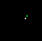

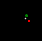

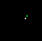

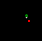

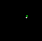

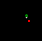

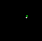

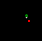

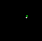

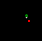

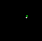

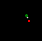

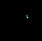

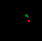

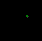

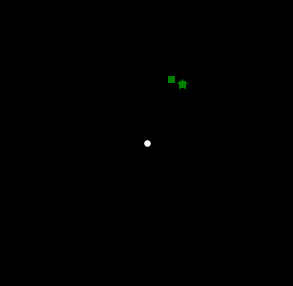

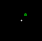

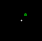

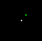

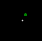

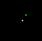

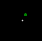

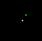

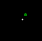

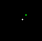

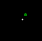

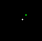

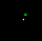

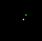

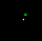

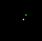

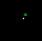

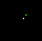

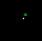

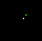

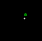

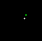

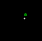

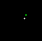

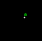

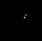

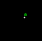

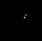

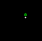

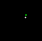

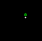

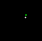

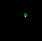

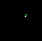

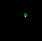

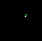

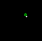

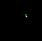

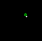

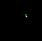

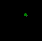

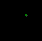

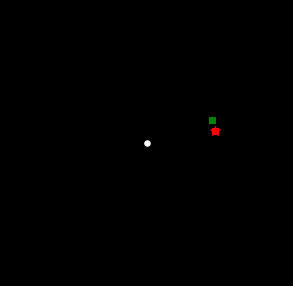

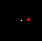

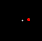

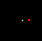

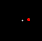

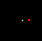

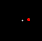

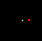

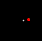

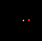

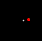

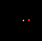

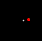

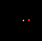

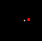

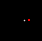

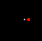

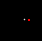

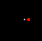

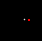

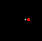

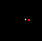

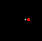

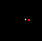

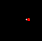

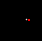

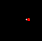

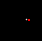

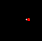

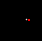

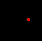

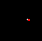

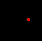

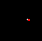

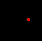

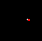

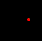

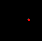

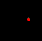

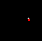

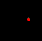

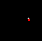

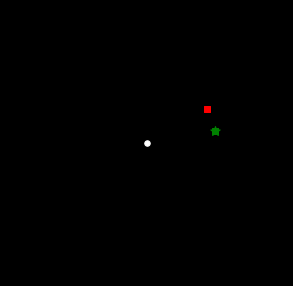

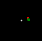

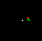

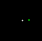

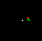

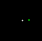

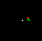

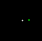

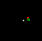

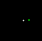

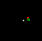

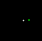

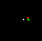

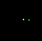

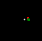

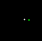

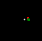

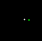

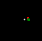

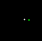

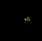

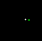

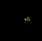

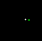

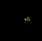

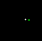

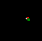

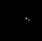

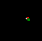

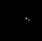

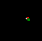

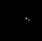

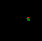

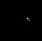

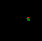

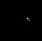

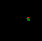

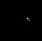

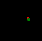

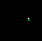

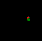

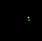

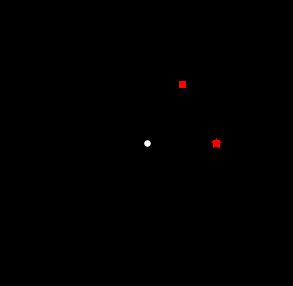

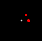

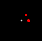

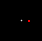

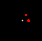

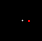

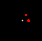

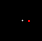

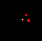

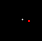

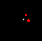

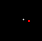

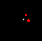

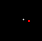

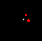

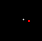

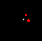

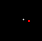

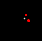

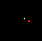

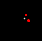

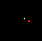

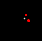

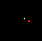

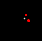

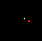

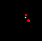

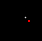

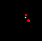

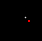

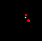

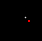

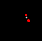

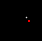

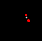

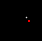

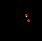

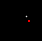

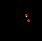

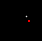

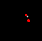

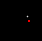

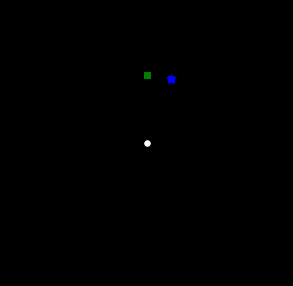

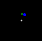

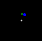

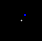

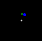

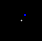

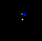

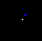

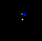

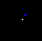

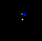

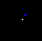

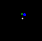

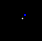

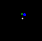

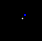

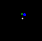

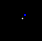

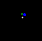

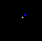

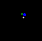

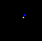

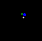

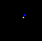

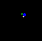

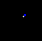

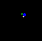

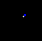

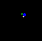

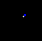

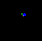

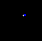

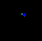

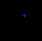

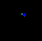

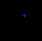

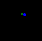

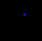

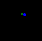

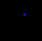

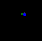

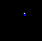

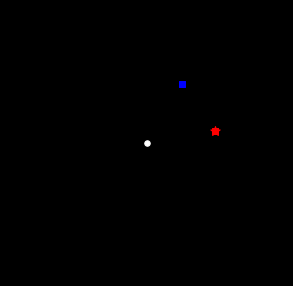

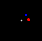

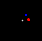

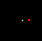

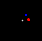

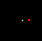

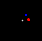

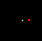

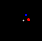

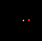

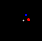

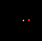

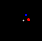

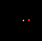

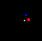

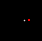

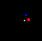

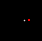

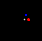

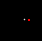

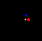

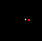

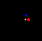

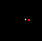

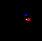

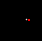

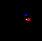

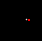

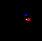

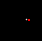

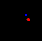

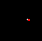

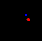

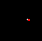

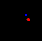

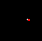

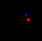

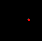

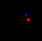

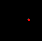

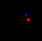

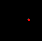

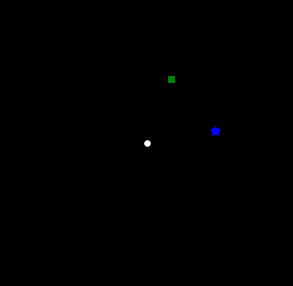

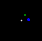

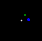

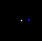

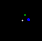

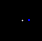

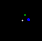

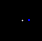

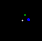

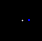

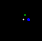

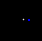

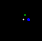

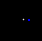

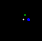

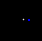

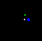

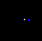

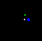

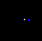

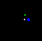

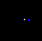

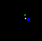

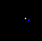

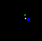

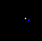

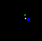

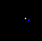

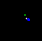

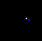

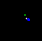

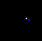

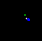

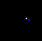

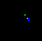

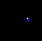

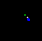

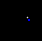

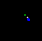

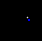

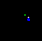

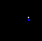

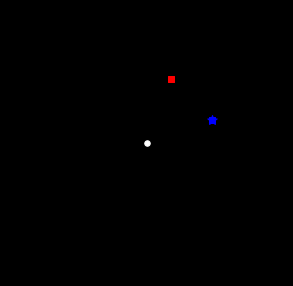

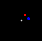

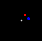

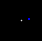

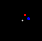

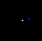

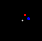

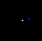

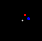

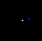

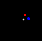

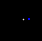

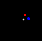

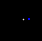

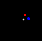

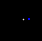

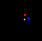

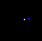

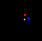

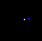

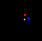

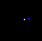

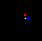

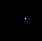

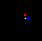

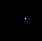

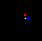

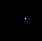

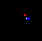

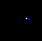

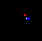

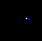

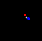

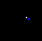

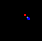

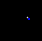

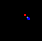

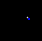

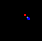

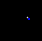

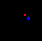

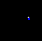

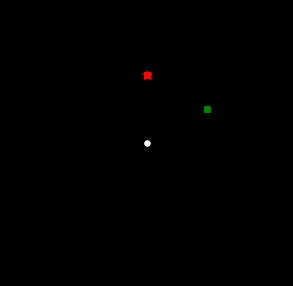

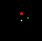

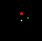

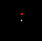

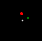

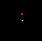

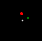

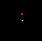

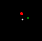

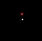

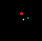

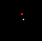

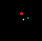

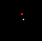

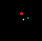

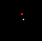

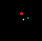

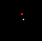

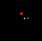

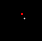

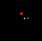

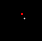

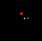

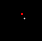

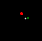

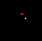

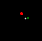

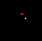

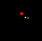

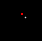

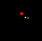

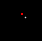

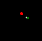

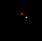

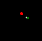

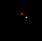

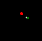

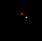

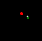

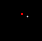

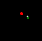

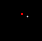

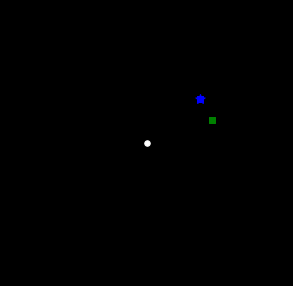

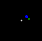

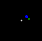

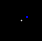

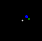

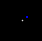

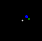

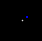

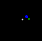

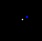

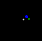

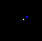

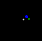

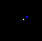

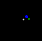

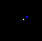

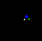

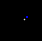

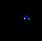

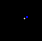

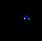

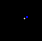

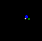

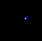

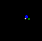

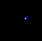

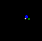

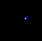

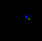

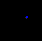

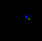

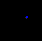

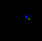

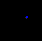

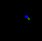

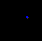

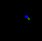

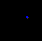

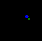

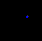

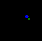

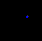

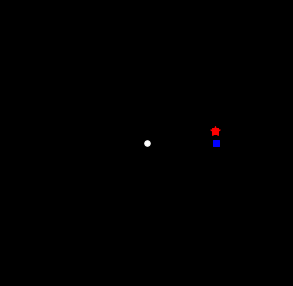

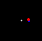

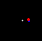

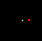

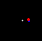

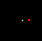

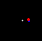

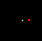

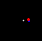

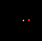

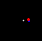

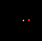

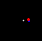

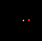

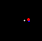

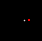

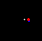

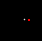

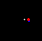

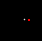

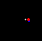

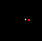

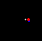

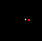

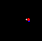

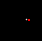

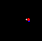

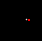

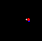

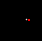

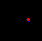

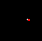

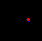

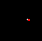

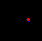

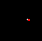

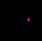

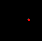

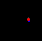

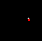

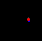

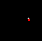

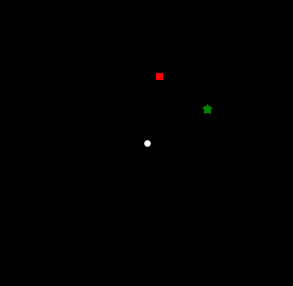

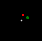

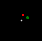

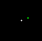

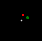

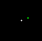

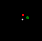

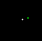

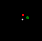

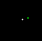

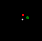

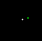

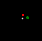

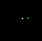

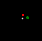

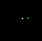

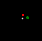

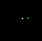

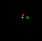

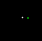

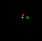

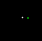

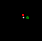

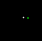

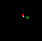

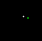

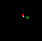

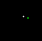

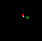

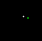

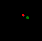

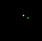

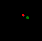

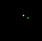

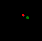

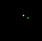

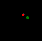

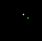

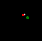

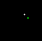

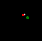

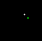

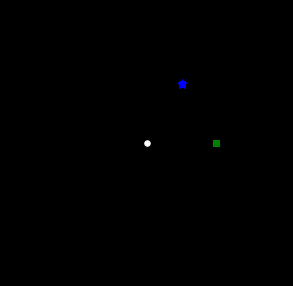

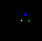

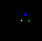

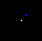

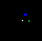

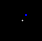

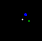

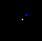

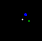

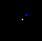

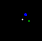

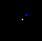

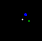

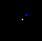

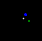

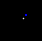

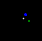

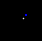

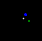

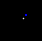

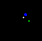

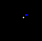

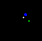

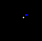

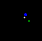

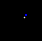

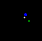

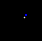

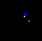

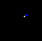

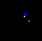

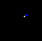

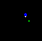

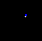

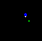

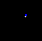

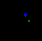

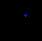

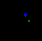

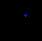

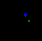

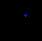

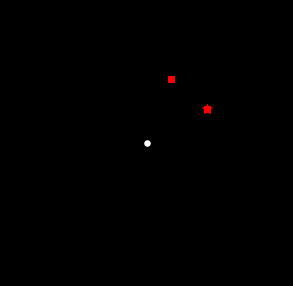

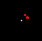

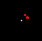

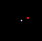

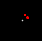

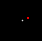

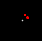

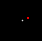

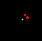

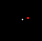

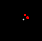

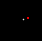

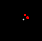

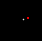

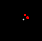

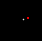

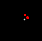

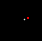

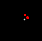

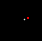

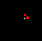

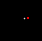

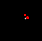

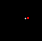

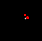

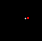

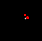

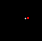

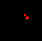

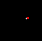

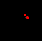

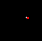

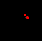

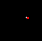

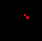

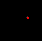

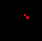

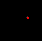

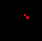

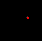

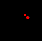

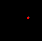

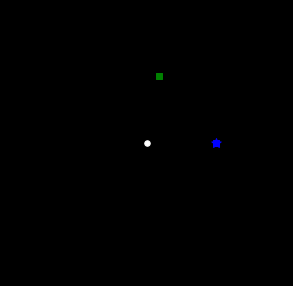

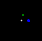

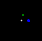

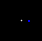

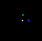

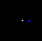

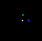

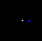

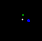

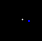

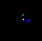

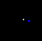

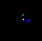

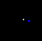

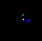

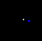

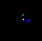

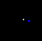

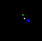

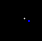

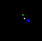

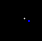

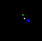

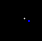

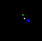

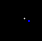

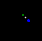

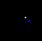

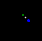

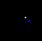

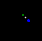

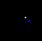

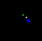

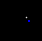

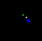

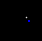

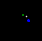

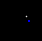

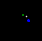

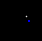

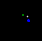

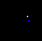

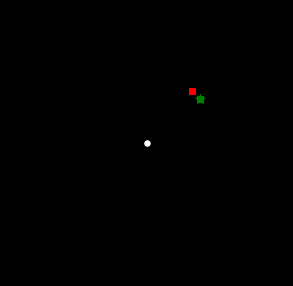

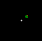

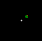

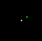

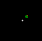

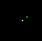

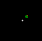

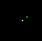

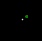

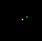

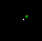

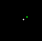

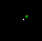

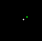

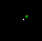

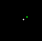

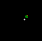

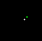

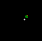

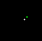

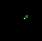

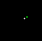

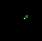

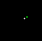

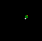

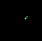

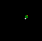

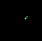

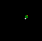

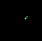

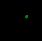

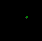

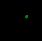

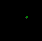

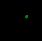

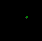

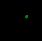

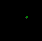

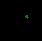

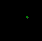

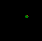

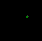

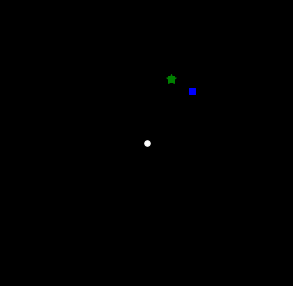

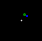

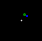

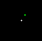

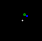

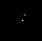

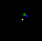

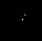

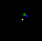

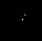

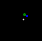

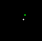

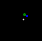

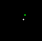

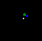

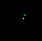

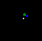

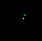

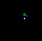

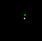

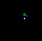

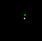

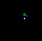

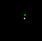

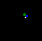

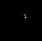

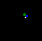

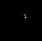

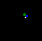

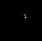

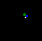

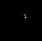

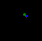

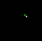

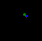

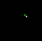

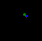

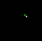

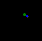

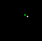

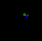

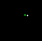

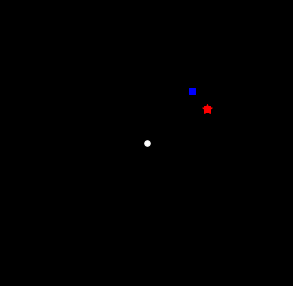

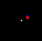

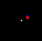

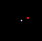

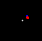

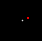

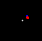

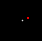

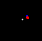

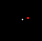

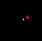

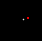

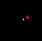

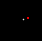

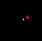

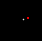

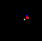

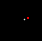

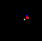

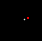

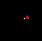

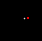

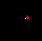

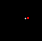

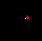

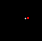

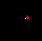

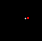

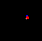

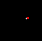

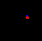

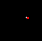

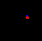

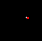

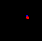

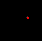

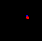

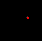

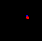

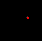

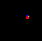

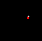

In [281]:
policy_copy.eval()
num_test_trajs = 50
# sets sampling for angles and colors
test_obj_angles = 90
test_obj_colors = [0,1,2]
discretize = 10

dist_to_goals = []
first_state = None
construal = None

for i in range(num_test_trajs):
    env.reset(test_obj_angles, test_obj_colors, discretize)
    plot_env(env)
    goal = torch.Tensor(env.goal_color[None]).to(device)
    #goal = torch.Tensor(lang_model.encode(env.goal)).to(device)
    o = plot_full_state(env.get_full_obs())
    first_state = o.copy()
    #construal = plot_construal(env.get_full_obs()).copy()
    
    traj = {'obs': [],'acts': [], 'true_goal': []}
    for i in range(20):
        state = torch.Tensor(o[None]).to(device)
        if mask:
            action, img_mask , masked_state = policy_copy(goal,state)
            action = action.cpu().detach().numpy()[0]
            img_mask = img_mask.cpu().detach().numpy()[0].transpose(1,2,0)
            masked_state = masked_state.cpu().detach().numpy()[0].transpose(1,2,0)
            if i == 0:
                first_masked_state = masked_state
        else:
            action = policy_copy(goal,state)[0].cpu().detach().numpy()[0]
        no, r, d, _ = env.step(action)
        traj['obs'].append(o.copy())
        traj['acts'].append(action.copy())
        traj['true_goal'].append(env.goal)
        o = plot_full_state(no.copy())
        construal=plot_construal(no.copy())
    traj['obs'] = np.array(traj['obs'])
    traj['acts'] = np.array(traj['acts'])
    traj['true_goal'] = np.array(traj['true_goal'])
    dist_to_goals.append(r.copy())
    #print("Final dist to goal: ", r)
    #plt.plot(traj['obs'][:, 0], traj['obs'][:, 1]) # plots trajs
print("Average dist to goal: ", np.mean(dist_to_goals))
print("Average std: ", np.std(dist_to_goals))